<a href="https://colab.research.google.com/github/morenourey/DSC_NUCLIO/blob/main/2_INTRO_TIME_SERIES27062024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Objetivos del notebook
---
Este notebook busca ser la referencia del alumno para temas de **Series Temporales**.

El notebook busca **combinar la parte teórica junto con la parte práctica** para facilitar la comprensión de los principales conceptos. Para ello a lo largo del notebook vamos a ir analizando diferentes series temporales para comprender mejor sus características.<br> Para poner en práctica todo lo aprendido vamos a **probar diferentes modelos y algoritmos de Machine Learning para Series Temporales para ver sus pros y sus contras**.

Al final del notebook, el alumno debe estar familiarizado con:

1. Series Temporales **estacionarias** y **no estacionarias (CORE IDEA)**.<br>
2. Diferenciar entre Series Temporales **univariante** y **multivariante**.<br>
3. Hacer un análisis visual de una serie temporal y determinar si tiene **tendencia (trend)**, **estacionalidad (seasonality)** o si tiene **ciclos (cycles)**.<br>
4. Conocer los modelos **AR(p) y MA(q)** y cual es la teoría detrás de ellos **(CORE IDEA)**.
5. Utilizar ACF y PACF para poder determinar los grados p y q de los modelos ARMA(pq) **(CORE IDEA)**.
6. Saber **ejecutar tests estadísticos** sobre una serie temporal y determinar si es estacionaria o no.
7. Saber utilizar **gridsearch** para determinar los mejores parametros de un modelo ARIMA(pdq).
8. Poder aplicar **diferentes transformaciones (CORE IDEA)** sobre la serie temporal para conseguir una serie estacionaria.
9. **Descomponer la serie temporal** en diferentes elementos (trend, seasonality y residuals).
10. Familiarizarse con la metodología de **Box-Jenkins** para el análisis de **Time Series Univariante**.
11. Aprender a construir **variables nuevas (CORE IDEA)** a partir de una serie temporal (sobre todo para modelos como XGBoost).
12. Saber evaluar la bondad de un modelo y poder **elegir entre diferentes algoritmos**.
13. Hacer una predicción sobre una serie temporal utilizando por lo menos estos algoritmos: **Naive Predictor, ARIMA, Exponential Smoothing, Prophet (CORE IDEA).**

Todo lo expuesto anteriormente nos permitirá implementar el forecasting con XGBoost en la sesión de Kaggle.

---

El presente notebook contiene muchas funcionalidades avanzadas que puede requerir varias lecturas para su comprensión.
Pensamos que las secciones marcadas con **CORE IDEA** son las que mayor beneficio le reportarán al alumno. Por este motivo, le animamos a que dedique especial atención a estas ideas.

Además se van a implementar diferentes algoritmos desde cero dado que es uno de los mejores metódos para aprender su funcionamiento.

Al final del notebook, hay un sección de referencias y lecturas recomendables para que el alumno pueda seguir profundizando en estos conceptos.

---

<a id='index'></a>
## Índice

[Imports del notebook](#imports_notebook)<br>

## Time Series
[Helpers Time Series](#helpers)<br>
[Time Series Plots](#plots)<br>
[Introducción a las Series Temporales](#intro)<br>
[Serie Temporal Univariante (STU)](#tsuni)<br>
[Introducción a ARIMA (pdq)](#intro_arima)<br>
[Modelos Auto Regresivos - AR(p) **(CORE IDEA)**](#arima_ar)<br>
[Modelos de Medias Móviles - MA(q) **(CORE IDEA)**](#arima_ma)<br>
[Modelo ARMA (pq)](#arma)<br>
[Series Temporal Estacionarias **(COREA IDEA)**](#ts_estacionarias)<br>
[Transformaciones de STU **(COREA IDEA)**](#transformaciones)<br>
[Tests Estadísticos para comprobar la estacionalidad](#tests)<br>
[ACF y PACF de STU](#acf_pacf)<br>
[Gridsearch de los parametros de un modelo ARIMA](#gridsearch)<br>
[Fit del modelo ARIMA(pdq)](#fit_arima)<br>
[Prophet](#prophet)<br>
[Holt Winters (**BONUS**)](#holt_winters)<br>

## Conclusión
[Conclusión](#conclusion)<br>

## Referencias
[Referencias y lecturas recomendables](#referencias)<br>

<a id='imports_notebook'></a>
# Imports del notebook
[Volver al índice](#index)

En este apartado hacemos los principales imports del notebook.<br>
Sobre todo vamos a trabajar con **numpy**, **pandas** y **statsmodels**.

In [1]:
# imports time series
import pandas as pd
import numpy as np

# plots
import matplotlib.pyplot as plt
%matplotlib inline

# para calculas métricas del modelo
from sklearn.metrics import mean_squared_error

# misc
import os
import time
import itertools
import warnings
warnings.filterwarnings("ignore")

# apartado ts
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing, Holt

from prophet import Prophet

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [18]:
DATA_PATH = "/content/drive/MyDrive/NUCLIO/time_series/data"

In [19]:
print("Working with these versions of libraries\n")
print("-"*50)
print(f"Numpy version {np.__version__}")
print(f"Pandas version {pd.__version__}")
print(f"Statsmodels version {sm.__version__}")

Working with these versions of libraries

--------------------------------------------------
Numpy version 1.25.2
Pandas version 2.0.3
Statsmodels version 0.14.2


# Time Series

<a id='helpers'></a>
# Helpers Time Series
[Volver al índice](#index)

En este apartado definimos varias funciones auxiliares. Sobre todo tienen que ver con la carga de los diferentes dfs para su mejor análisis posterior.

In [20]:
def load_google_data(path_google_data):
    '''
    Loads the Google Stock Price df.
    '''
    df = pd.read_csv(path_google_data)

    df["Date"] = pd.to_datetime(df["Date"], format = "%d/%m/%Y")

    df = df[["Date", "Adj Close"]]
    df.columns = ["ds", "y"]
    df["origin"] = "Google"

    return df

In [7]:
def load_beer_data(path_beer_data):
    '''
    Loads the Austrialian Beer Consumption df.
    '''
    df = pd.read_csv(path_beer_data)

    df["Month"] = pd.to_datetime(df["Month"], format = "%Y-%m")

    df = df[["Month", "Monthly beer production"]]
    df.columns = ["ds", "y"]
    df["origin"] = "Beer"

    return df

In [8]:
def load_passangers_data(path_passangers_data):
    '''
    Loads Air Passangers df.
    '''
    df = pd.read_csv(path_passangers_data)

    df["Month"] = pd.to_datetime(df["Month"], format = "%Y-%m")

    df = df[["Month", "#Passengers"]]
    df.columns = ["ds", "y"]
    df["origin"] = "Passangers"

    return df

In [9]:
def load_lynx_data(path_lynx_data):
    '''
    Loads Lynx Population df.
    '''
    df = pd.read_csv(path_lynx_data)

    df["Año"] = df["Año"].apply(lambda str_date: str_date.split("-")[0])
    df["Año"] = pd.to_datetime(df["Año"], format = "%Y")

    df = df[["Año", "Pieles"]]
    df.columns = ["ds", "y"]
    df["origin"] = "Lynx"

    return df

In [10]:
def load_house_data(path_house_data):
    '''
    Loads the House df.
    '''
    df = pd.read_csv(path_house_data)

    df["DATE"] = pd.to_datetime(df["DATE"], format = "%Y-%m-%d")

    df = df[["DATE", "HSN1F"]]
    df.columns = ["ds", "y"]
    df["origin"] = "House"

    return df

In [11]:
def generate_rw_data():
    '''
    Generates a random walk ts data.
    '''
    RW = [0]

    for i in range(1000):
        ytm1 = RW[-1]
        wn = np.random.randn()

        yt = ytm1 + wn

        RW.append(yt)

    df = pd.DataFrame(
        data = RW,
        index = pd.date_range(start = np.datetime64("1970-01-01"), periods = len(RW), freq = "D")
    )

    df.reset_index(inplace = True)
    df.columns = ["ds", "y"]

    df["origin"] = "RW"

    return df

In [12]:
def load_rw_data(path_rw_data):
    '''
    Loads random walk df.
    '''
    df = pd.read_csv(path_rw_data, index_col = 0)

    df["ts"] = pd.to_datetime(df["ts"], format = "%Y-%m-%d")

    df.columns = ["ds", "y", "origin"]

    return df

In [13]:
def load_prophet_data(path_prophet_data):
    '''
    Loads ideal ts for prophet forecasting.
    '''
    df = pd.read_excel(path_prophet_data, index_col = 0)

    df["yhat"] = df["yhat"]/1_000_000
    df.columns = ["ds", "y", "origin"]

    return df

In [14]:
def load_ts_data():
    '''
    Loads all available ts data.
    '''
    google_df = load_google_data(path_google_data = os.path.join(DATA_PATH, "ts_google.csv"))
    beer_df = load_beer_data(path_beer_data = os.path.join(DATA_PATH, "ts_beer.csv"))
    passangers_df = load_passangers_data(path_passangers_data = os.path.join(DATA_PATH, "ts_passangers.csv"))
    lynx_df = load_lynx_data(path_lynx_data = os.path.join(DATA_PATH, "ts_lynx.csv"))
    house_df = load_house_data(path_house_data = os.path.join(DATA_PATH, "ts_house.csv"))
    rw_df = load_rw_data(path_rw_data = os.path.join(DATA_PATH, "ts_rw.csv"))
    prophet_df = load_prophet_data(path_prophet_data = os.path.join(DATA_PATH, "ts_prophet.xlsx"))

    df = pd.concat(
        [
            google_df,
            beer_df,
            passangers_df,
            lynx_df,
            house_df,
            rw_df,
            prophet_df
        ]
    )

    df.sort_values(["origin", "ds"], ascending = True, inplace = True)

    return df

<a id='plots'></a>
# Time Series Plots
[Volver al índice](#index)

Antes de entrar en la terminología básica de las Series Temporales, vamos a intentar coger algo de intuición sobre ellas.

**La forma más sencilla y directa es haciendo algunos plots.**

In [15]:
def fit_straight_line(y, deg = 1):
    '''
    Fits a straight line between 2 data points.
    '''
    x_values = np.linspace(0, 1, len(y))

    coeffs = np.polyfit(x = x_values, y = y, deg = deg)
    poly_eqn = np.poly1d(coeffs)

    y_hat = poly_eqn(x_values)

    return y_hat

def plot_single_ts(df, ax, origin, target_column, fit_line):
    '''
    Plots a Time Series data based on the origin you pass.
    '''
    x = df[df["origin"] == origin]["ds"]
    y = df[df["origin"] == origin][target_column]

    if fit_line:
        y_hat = fit_straight_line(y = y)
        ax.plot(x, y_hat, color = "orange", label = "Trend")

    ax.plot(x, y, label = origin, lw = 4)
    ax.legend(loc = "upper left")

def plot_time_series(df, target_column, fit_line):
    '''
    Plots all the available time series.
    '''
    fig = plt.figure(figsize = (15, 30))
    (ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10, ax11) = fig.subplots(11, 1)

    plot_single_ts(df = df, ax = ax1, origin = "Google", target_column = target_column, fit_line = fit_line)
    plot_single_ts(df = df, ax = ax2, origin = "Beer", target_column = target_column, fit_line = fit_line)
    plot_single_ts(df = df, ax = ax3, origin = "Passangers", target_column = target_column, fit_line = fit_line)
    plot_single_ts(df = df, ax = ax4, origin = "Lynx", target_column = target_column, fit_line = fit_line)
    plot_single_ts(df = df, ax = ax5, origin = "House", target_column = target_column, fit_line = fit_line)
    plot_single_ts(df = df, ax = ax6, origin = "RW", target_column = target_column, fit_line = fit_line)
    plot_single_ts(df = df, ax = ax7, origin = "Sector_1", target_column = target_column, fit_line = fit_line)
    plot_single_ts(df = df, ax = ax8, origin = "Sector_2", target_column = target_column, fit_line = fit_line)
    plot_single_ts(df = df, ax = ax9, origin = "Sector_3", target_column = target_column, fit_line = fit_line)
    plot_single_ts(df = df, ax = ax10, origin = "Sector_4", target_column = target_column, fit_line = fit_line)
    plot_single_ts(df = df, ax = ax11, origin = "Sector_5", target_column = target_column, fit_line = fit_line)

    fig.tight_layout()

### Pregunta 1: ¿Que podemos decir de las siguientes Series Temporales?

Queremos contestar este tipo de preguntas:

¿Presentan las series temporales alguna tendencia creciente?

¿Hay alguna serie temporal que presenta diferente varianza a lo largo del tiempo?

¿Podemos observar algunos ciclos en la serie temporal?

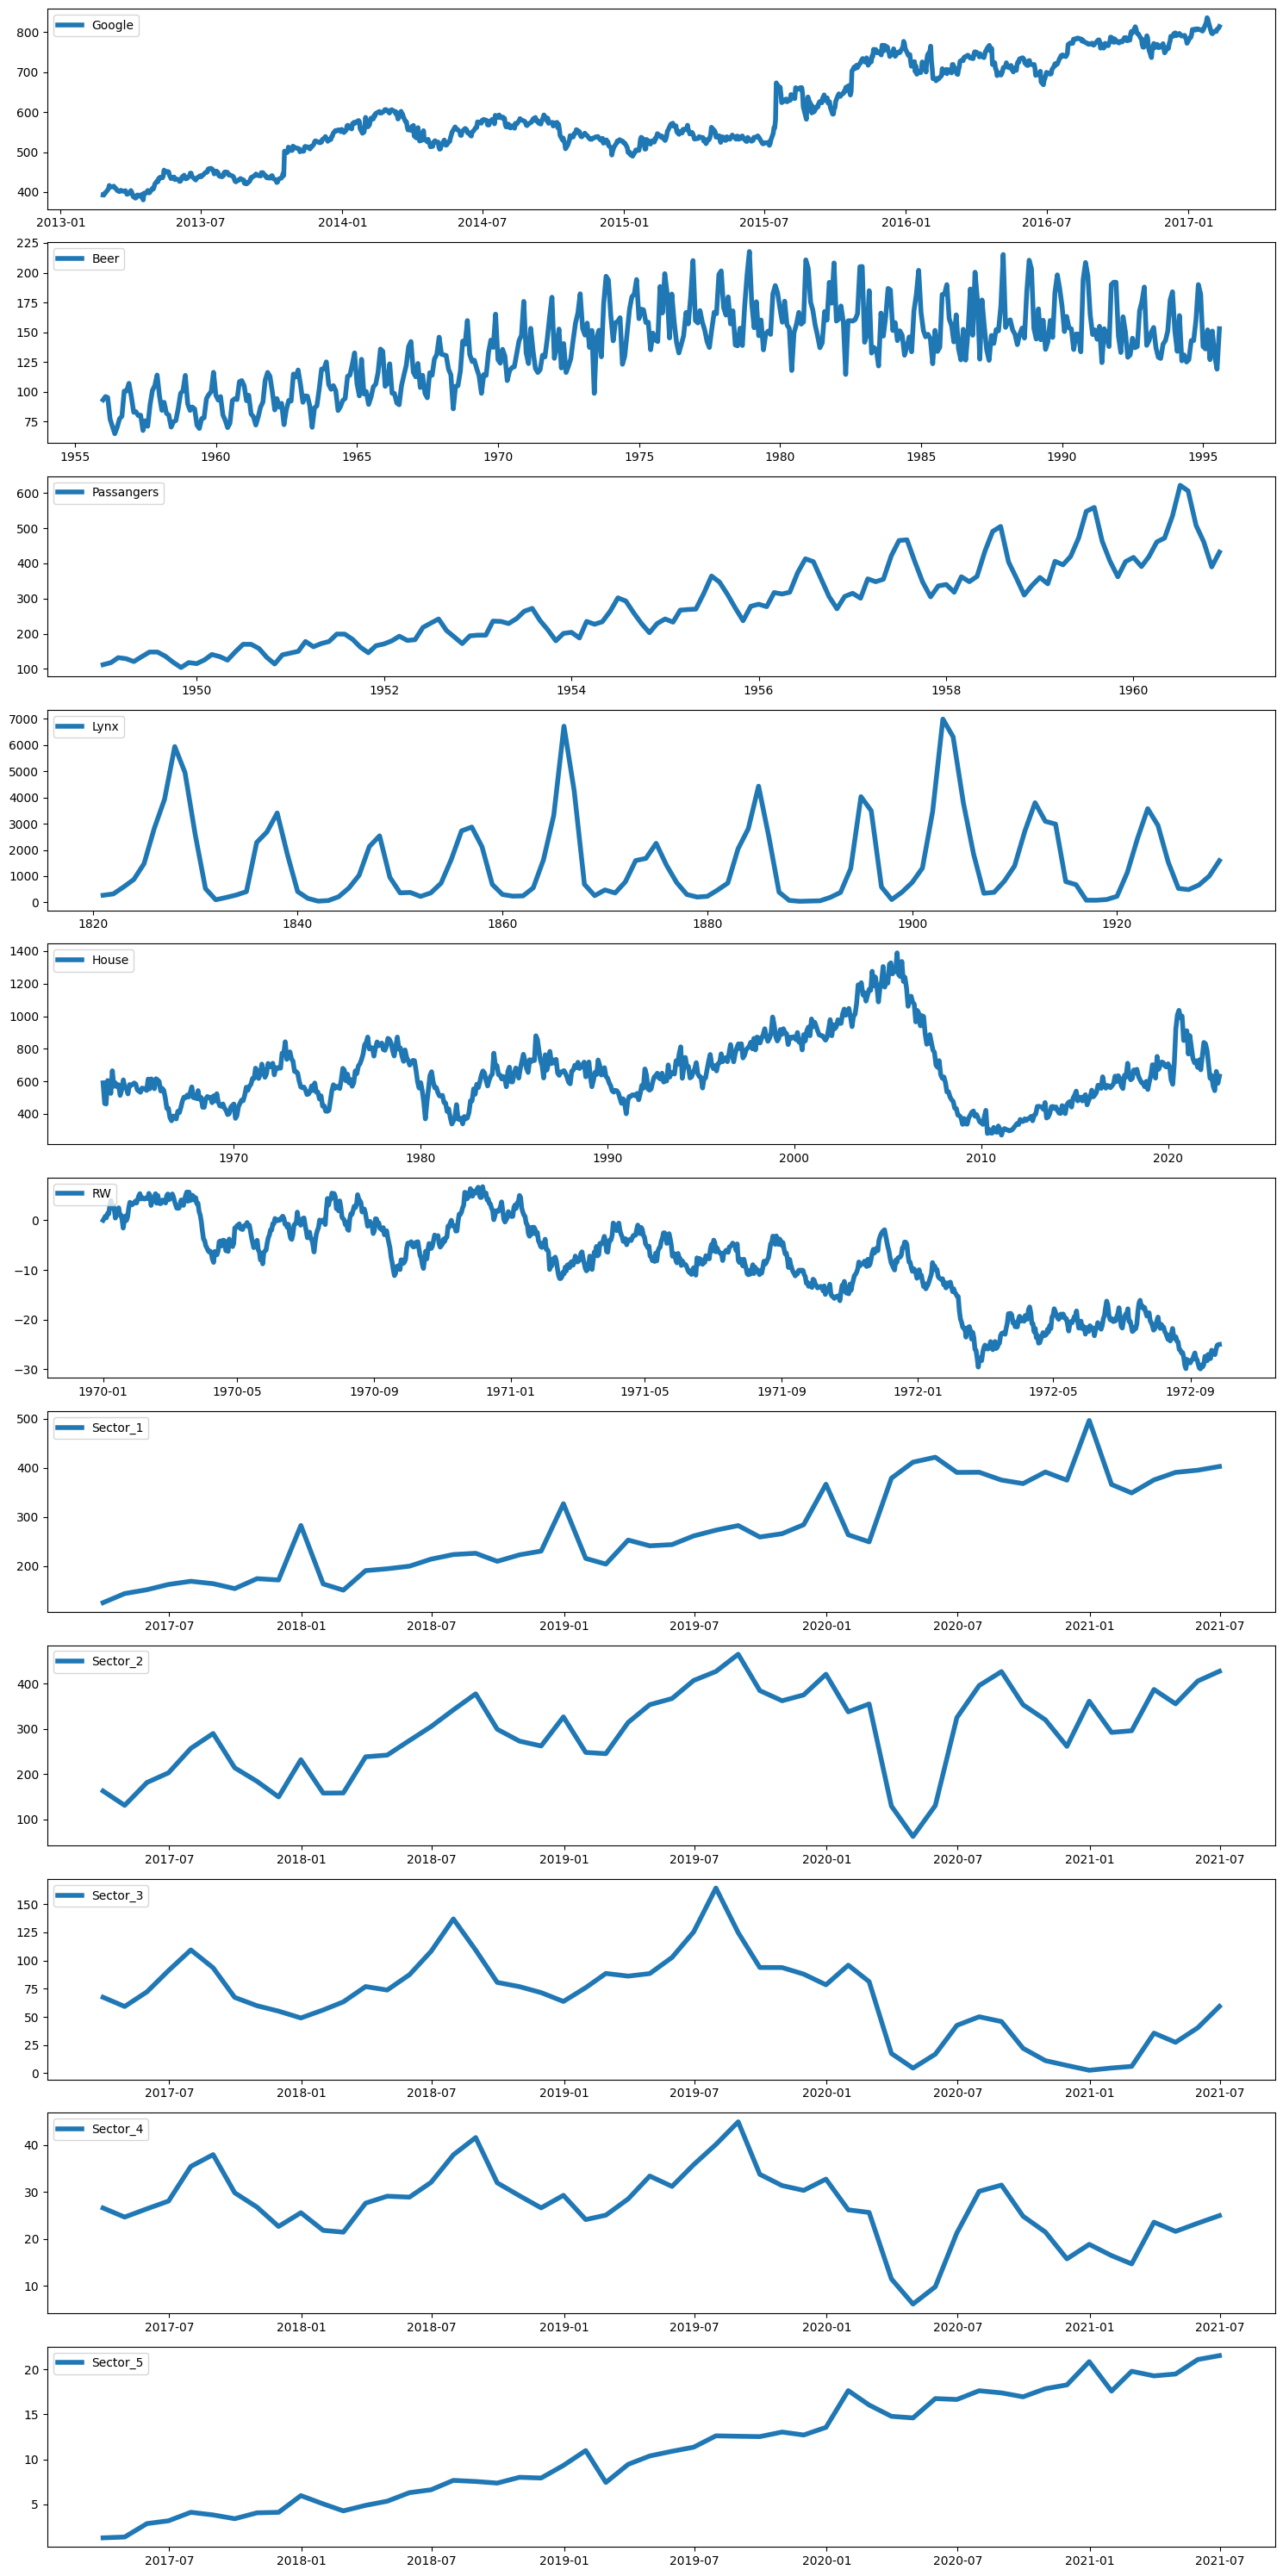

In [21]:
df = load_ts_data()
plot_time_series(df = df, target_column = "y", fit_line = False)

In [22]:
df.head()

,ds,y,origin
0,1956-01-01,93.2,Beer
1,1956-02-01,96.0,Beer
2,1956-03-01,95.2,Beer
3,1956-04-01,77.1,Beer
4,1956-05-01,70.9,Beer


<a id='intro'></a>
# Introducción a las Series Temporales
[Volver al índice](#index)

La serie temporal no es más que un conjunto de datos **ordenados** en el tiempo. Estos datos han sido recogidos durante un periodo determinado (por ejemplo datos de todo un año) y durante unos intervalos concretos (por ejemplo cada 12 horas durante un año). Por este motivo, la mayoría de las Series Temporales son una **secuencia de datos observados en periodos de tiempo discretos**.

El análisis de las Series Temporales es un campo con mucho desarrollo teórico detrás. Algunos de los métodos que se siguen utilizando hoy en día han sido desarollados hace más de medio siglo (por ejemplo **ARIMA(pqd)**). El motivo de tanto interés hacia las TS se debe a que muchos problemas de la vida real se pueden ver como un problema de Time Series.

Veamos algunas casos concretos:
1. Las empresas necesitan estimar las ventas que tendrán el próximo año. Conocer esta información les va a permitir ajustar sus compras a proveedores y también planificar mejor la contratación de personal.
2. Un analista de un hedge fund puede necesitar estimar la demanda que habrá dentro de un sector de la economía para hacer cambios en su cartera de inversión (invertir o desinvertir en determinadas empresas).
3. El gobierno quiere saber la recaudación que va a tener durante un periodo determinado porque de ellos dependerá su gasto fiscal.

Como podemos comprobar con los ejemplos anteriores, hay infinidad de situaciones a las que nos enfrentamos en la vida real y que se pueden ver como una **Serie Temporal**.

A la hora de clasificar las Series Temporales podemos distinguir entre Serie Temporal **Univariante y Multivariante:**<br> **Univariante** es la serie temporal más sencilla. En este caso el dataset únicamente contiene 2 columnas: el tiempo (**ds**) y el valor a predecir (**y**).<br> En cambio, las **Series Temporales Multivariante** contienen tanto la columna de tiempo (**ds**), el valor a predecir (**y**) y también otras series temporales que nos podrían ayudar a predecir el target (**y**). Por ejemplo: queremos predecir el gasto en los bares de las costas españolas en función del número de turistas que han visitado el país, el tiempo que hace y el número de actividades sociales que habrá (conciertos, fiestas etc).<br>

En este notebook, sobre todo vamos a tratar con series temporales **univariante**.

<a id='tsuni'></a>
# Serie Temporal Univariante (STU)
[Volver al índice](#index)

La Series Temporal Univariante según hemos visto antes es la serie temporal más sencilla, ya que sólo contiene 2 columnas: **la fecha (ds) y el valor a predecir (y)**.

Todas las TS mostradas anteriormente son univariante.

In [ ]:
ts_lynx = df[df["origin"] == "Lynx"][["ds", "y"]]

In [ ]:
# tenemos dos columnas y nos interesa poder predecir como va a evolucionar nuestro target: columna y
ts_lynx.head()

,ds,y
0,1821-01-01,269.0
1,1822-01-01,321.0
2,1823-01-01,585.0
3,1824-01-01,871.0
4,1825-01-01,1475.0


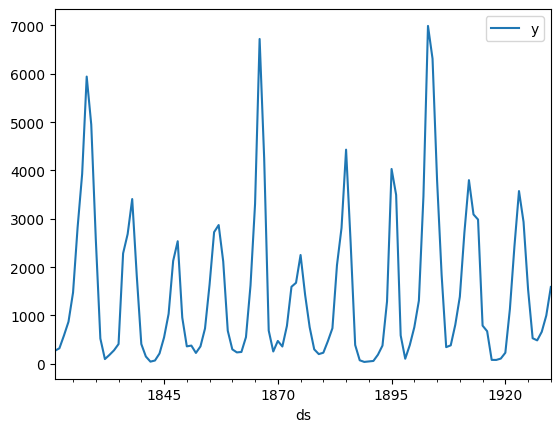

In [ ]:
# veamos de nuevo nuestro plot
ts_lynx.set_index("ds").plot();

## BRAINSTORMING

### Pregunta 2: Teniendo la TS anterior, si nos solicitan una predicción ¿como podríamos enfocar esta modelización?

<a id='intro_arima'></a>
# Introducción a ARIMA (pdq)
[Volver al índice](#index)

En la sección anterior hemos ido proponiendo diferentes enfoques a la hora de intentar hacer un forecasting.

Entre las ideas claves que nos han ido surgiendo tenemos:
1. Asumir que **mañana será igual que hoy**. Por tanto mi predicción es el último valor disponible de la TS. De hecho, en TS este **enfoque naive** es casi siempre el benchmark de partida.
2. Predecir para mañana **la media móvil (MA(q))** de los últimos n registros disponibles.
3. Predecir para mañana un valor que depende **de los valores del pasado (AR(p))**. Es decir, el futuro es una combinación lineal del pasado.

En la presente sección, vamos a intentar formalizar un poco más todo lo que ha ido surgiendo de la sección de brainstorming. Con especial enfásis en la parte 2 y 3.

<a id='arima_ar'></a>
# Modelos Auto Regresivos - AR(p) (CORE IDEA)
[Volver al índice](#index)

Cuando tengo una **Serie Temporal Univariante (STU)**, tengo tanto mis variables (X) como el target (Y) en una misma columna. Además, por definición no dispongo de más información (variables externas) porque ya no sería una STU.

Por este motivo, hay que hacer varias asunciones sobre mi Serie Temporal antes de empezar a trabajar con ella.

### La primera propiedad que vamos a suponer que presenta la STU es que la Serie Temporal contiene toda la información necesaria para hacer el forecast a futuro. Dicho de otra manera, los valores del pasado influyen en el futuro y la Serie Temporal contiene toda esta información relevante para poder predecirlo.

Cuando yo aplico este enfoque en la modelización de una STU, estoy suponiendo que la Serie Temporal es **Auto Regresiva (AR).** Es enfoque es muy sencillo de comprender y es muy intuitivo. Suponer que la Serie Temporal es AR me da el background teórico necesario para poder plantear un **modelo lineal en base a los valores del pasado**. Es justo el 3 apartado comentado antes.

Veamos a nivel de código como puedo generar estas variables.

In [ ]:
ts_lynx["y_ar_lag_1"] = ts_lynx["y"].shift(1)
ts_lynx["y_ar_lag_2"] = ts_lynx["y"].shift(2)
ts_lynx["y_ar_lag_3"] = ts_lynx["y"].shift(3)
ts_lynx

,ds,y,y_ar_lag_1,y_ar_lag_2,y_ar_lag_3
0,1821-01-01,269.0,NaN,NaN,NaN
1,1822-01-01,321.0,269.0,NaN,NaN
2,1823-01-01,585.0,321.0,269.0,NaN
3,1824-01-01,871.0,585.0,321.0,269.0
4,1825-01-01,1475.0,871.0,585.0,321.0
...,...,...,...,...,...
105,1926-01-01,529.0,1537.0,2935.0,3574.0
106,1927-01-01,485.0,529.0,1537.0,2935.0
107,1928-01-01,662.0,485.0,529.0,1537.0
108,1929-01-01,1000.0,662.0,485.0,529.0


Cuando hablamos de Series Temporales, a las variables que construimos y que tienen que ver con el pasado les llamamos **"Lags" o "Shifts"**.

En la celda de código anterior, hemos construido hasta 3 variables nuevas gracias a esta técnica.

#### Nota: para los primeros registros, no disponemos de lags porque es el comienzo de la serie temporal y no había recogido información previa. De alguna manera, sacrifiqué 3 filas para construir 3 columnas nuevas.

---

El modelo Auto Regresivo AR(p) **lo podemos formalizar de la siguiente manera**:

## Yt = Φ1Yt-1 + Φ2Yt-2 + Φ3Yt-3 + αt

Donde:

**Yt**: es la Serie Temporal que intentamos ajustar.<br>
**Yt-1**: es el valor del año anterior (lag de 1).<br>
**Yt-2**: es el valor del hace 2 años (lag de 2).<br>
**Yt-3**: es el valor del hace 3 años (lag de 3).<br>
**Φ1 (phi1)**: es el coeficiente de Yt-1. Por tanto el peso que tendrá Yt-1 en la ecuación final.<br>
**Φ2 (ph2)**: es el coeficiente de Yt-2. Por tanto el peso que tendrá Yt-2 en la ecuación final.<br>
**Φ3 (phi3)**: es el coeficiente de Yt-3. Por tanto el peso que tendrá Yt-3 en la ecuación final.<br>
**αt**: residuo del modelo. Aquello que mi modelo no puede recoger.<br>

#### Nota: a modo de ejemplo utilizamos 3 lags, por tanto mi modelo es un AR(p = 3). Es decir, el grado del modelo AR es p = 3.

---

Por supuesto yo puedo generalizar la formula anterior a **p pasos AR(p)**.

## <span style="color:#2A3990">Yt = Φ1Yt-1 + Φ2Yt-2 + Φ3Yt-3 + ... + ΦpYt-p + αt</span>

---
### Pregunta 3: ¿Que es más imporante: saber el número de lags del modelo o saber el peso/valor de los coeficientes Φ (phi)?

<a id='arima_ma'></a>
# Modelo de Medias Móviles - MA(q) (CORE IDEA)
[Volver al índice](#index)

En la sección anterior hemos visto un enfoque muy intuitivo que me permite modelizar una **Serie Temporal Univariante (STU)**.

Veamos ahora otro enfoque clásico y que tiene que ver con las medias móviles.

A menudo en la literatura se presenta el modelo de **Medias Móviles** como un modelo donde intentamos predecir la serie temporal Yt en función de los **errores del pasado**. Es decir, **Yt es una combinación lineal de los errores del pasado**. Esto claramente no facilita la comprensión del modelo y añade una capa de complejidad innecesaria.

Veamos una explicación un poco más intuitiva de este enfoque. <br>
En el modelo de Medias Móviles (MA), asumimos que nuestra serie temporal oscila entorno a una media histórica. Por tanto, lo que vamos a predecir siempre es la media histórica pero incorporaremos las desviaciones que ha tenido la serie de media histórica (los errores del pasado) en nuestro forecasting.

Veamos con un ejemplo práctico como podemos **"calcular estos errores"**.

In [ ]:
ts_lynx["y_mean"] = ts_lynx["y"].mean()

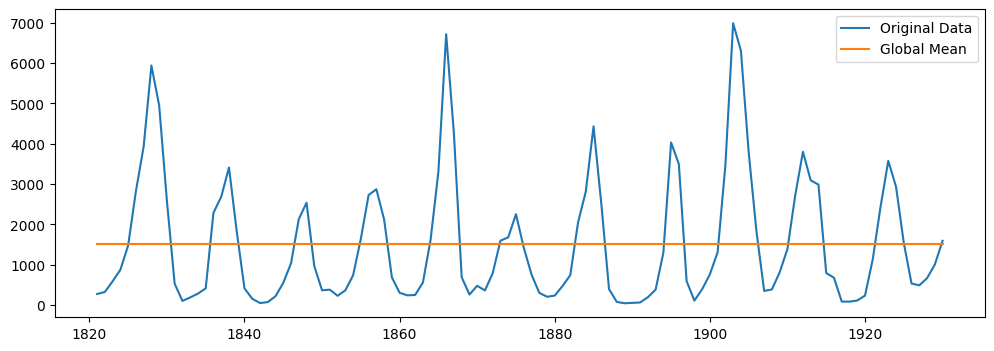

In [ ]:
fig = plt.figure(figsize = (12, 4))
ax = fig.add_subplot()

x = ts_lynx["ds"]
y = ts_lynx["y"]
y_mean = ts_lynx["y_mean"]

ax.plot(x, y, label = "Original Data")
ax.plot(x, y_mean, label = "Global Mean")

plt.legend();

In [ ]:
ts_lynx["error"] = ts_lynx["y"] - ts_lynx["y_mean"]

In [ ]:
ts_lynx["error_1"] = ts_lynx["error"].shift(1)
ts_lynx["error_2"] = ts_lynx["error"].shift(2)
ts_lynx["error_3"] = ts_lynx["error"].shift(3)

In [ ]:
ts_lynx.tail()

,ds,y,y_ar_lag_1,y_ar_lag_2,y_ar_lag_3,y_mean,error,error_1,error_2,error_3
105,1926-01-01,529.0,1537.0,2935.0,3574.0,1506.627273,-977.627273,30.372727,1428.372727,2067.372727
106,1927-01-01,485.0,529.0,1537.0,2935.0,1506.627273,-1021.627273,-977.627273,30.372727,1428.372727
107,1928-01-01,662.0,485.0,529.0,1537.0,1506.627273,-844.627273,-1021.627273,-977.627273,30.372727
108,1929-01-01,1000.0,662.0,485.0,529.0,1506.627273,-506.627273,-844.627273,-1021.627273,-977.627273
109,1930-01-01,1590.0,1000.0,662.0,485.0,1506.627273,83.372727,-506.627273,-844.627273,-1021.627273


¿De donde sale el valor 83.37?

Es el resultado de restar a 1590 la media histórica de 1506.

En el ejemplo anterior, estoy trabajando con una media histórica, veamos ahora como podemos calcular la media móvil con pandas.

In [ ]:
ts_lynx["y_ma_3"] = ts_lynx["y"].shift(1).rolling(window = 3).mean()
ts_lynx["y_ma_6"] = ts_lynx["y"].shift(1).rolling(window = 6).mean()
ts_lynx["y_ma_9"] = ts_lynx["y"].shift(1).rolling(window = 9).mean()
ts_lynx["y_ma_12"] = ts_lynx["y"].shift(1).rolling(window = 12).mean()
ts_lynx.head(10)

,ds,y,y_ar_lag_1,y_ar_lag_2,y_ar_lag_3,y_mean,error,error_1,error_2,error_3,y_ma_3,y_ma_6,y_ma_9,y_ma_12
0,1821-01-01,269.0,NaN,NaN,NaN,1506.627273,-1237.627273,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1822-01-01,321.0,269.0,NaN,NaN,1506.627273,-1185.627273,-1237.627273,NaN,NaN,NaN,NaN,NaN,NaN
2,1823-01-01,585.0,321.0,269.0,NaN,1506.627273,-921.627273,-1185.627273,-1237.627273,NaN,NaN,NaN,NaN,NaN
3,1824-01-01,871.0,585.0,321.0,269.0,1506.627273,-635.627273,-921.627273,-1185.627273,-1237.627273,391.666667,NaN,NaN,NaN
4,1825-01-01,1475.0,871.0,585.0,321.0,1506.627273,-31.627273,-635.627273,-921.627273,-1185.627273,592.333333,NaN,NaN,NaN
5,1826-01-01,2821.0,1475.0,871.0,585.0,1506.627273,1314.372727,-31.627273,-635.627273,-921.627273,977.000000,NaN,NaN,NaN
6,1827-01-01,3928.0,2821.0,1475.0,871.0,1506.627273,2421.372727,1314.372727,-31.627273,-635.627273,1722.333333,1057.000000,NaN,NaN
7,1828-01-01,5943.0,3928.0,2821.0,1475.0,1506.627273,4436.372727,2421.372727,1314.372727,-31.627273,2741.333333,1666.833333,NaN,NaN
8,1829-01-01,4950.0,5943.0,3928.0,2821.0,1506.627273,3443.372727,4436.372727,2421.372727,1314.372727,4230.666667,2603.833333,NaN,NaN
9,1830-01-01,2577.0,4950.0,5943.0,3928.0,1506.627273,1070.372727,3443.372727,4436.372727,2421.372727,4940.333333,3331.333333,2351.444444,NaN


¿De donde sale le valor 391.666667?

No es mas que la suma de (269 + 321 + 585) / 3 = 391.67

In [ ]:
round((269 + 321 + 585)/3, 2)

391.67

### Pregunta 4: ¿Porque hago el shift en la fórmula para calcular la media móvil?

ts_lynx["y"]**.shift(1).**rolling(window = 3).mean()

**Importante: aunque antes había dicho que estoy hablando de una media histórica y ahora estoy hablando de medias móviles, veremos más adelante una condición que debe satisfacer toda STU para poder utilizar este enfoque de trabajo. En la práctica, me dará igual utilizar la media histórica o bien la media móvil.**

Formalmente, si asumo que αt son los errores del pasado (desviación de los lags respecto a la media histórica) puedo describir mi modelo como:

## Yt = αt - Θ1αt-1 – Θ2αt-2 – Θ3αt-3

Donde:

**Yt**: es la Serie Temporal que intentamos ajustar.<br>
**αt-1**: es el error del periodo anterior (lag_1 - media histórica).<br>
**αt-2**: es el error de hace 2 periodos (lag_2 - media histórica).<br>
**αt-3**: es el error de hace 3 periodos (lag_3 - media histórica).<br>
**Θ1 (theta1)**: es el coeficiente de αt-1. Por tanto el peso que tendrá αt-1 en la ecuación final.<br>
**Θ2 (theta2)**: es el coeficiente de αt-2. Por tanto el peso que tendrá αt-2 en la ecuación final.<br>
**Θ3 (theta3)**: es el coeficiente de αt-3. Por tanto el peso que tendrá αt-3 en la ecuación final.<br>
**αt**: residuo del modelo. Aquello que mi modelo no puede recoger.<br>

#### Nota: a modo de ejemplo utilizamos 3 errores, por tanto mi modelo es un MA(q = 3). Es decir, el grado del modelo MA es q = 3.
---
Por supuesto yo puedo generalizar la formula anterior a **q pasos MA(q)**.

## <span style="color:#2A3990">Yt = αt - Θ1αt-1 – Θ2αt-2 – Θ3αt-3 - ... - Θqαt-q</span>

---
### Pregunta 5: ¿Que es más imporante: saber el grado del modelo MA o saber el peso/valor de los coeficientes Θ (theta)?

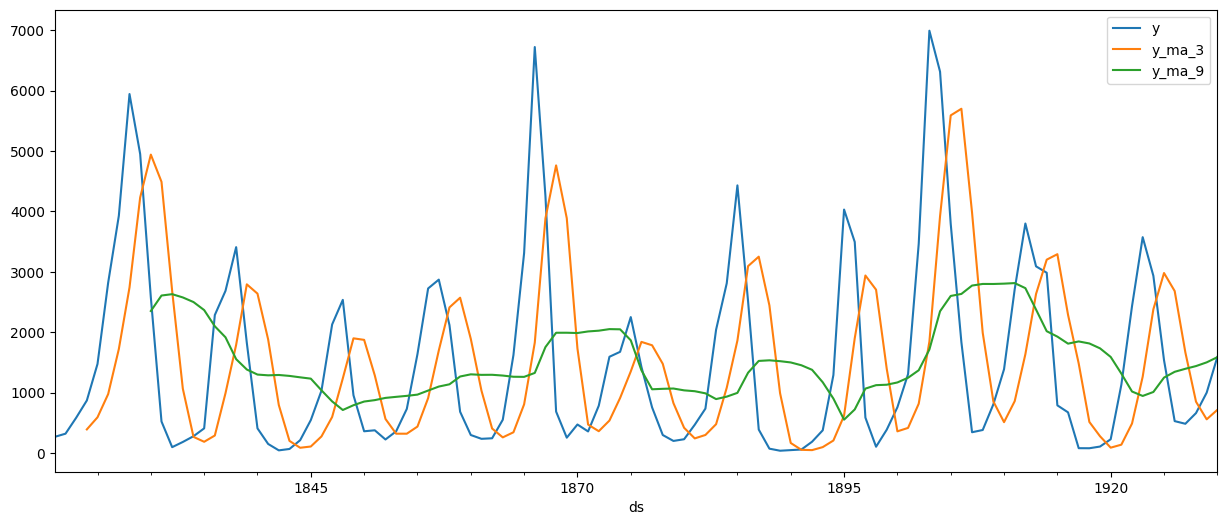

In [ ]:
# otra propiedad interesante de las medias móviles es que "suavizan" nuestra serie temporal.
# si nos fijamos, vemos que conforme abarco una mayor ventana más suave es la serie temporal resultante.
# Esta idea será muy relevante cuando vamos a hablar del método Holt Winters
(ts_lynx.set_index("ds")[
    [
        "y",
        "y_ma_3",
        "y_ma_9"
    ]
].plot(figsize = (15, 6)));

<a id='arma'></a>
# Modelo ARMA (pq)
[Volver al índice](#index)

Como bien os podéis imaginar, **los modelos AR(p) y MA(q)** no son excluyentes.

En realidad, los podemos combinar y obtener un modelo mucho mas versátil. Estamos hablando del modelo **ARMA(pq)** que contiene una parte Auto Regresiva y una parte de Medias Móviles y **los p y q son los grados respectivos del modelo.**

Formalmente podemos describir el modelo ARMA(p = 3, q = 3) de la siguiente manera:

## <span style="color:#2A3990">Yt = Φ1Yt-1 + Φ2Yt-2 + Φ3Yt-3 + αt – Θ1αt-1 – Θ2αt-2 – Θ3αt-3</span>

**Nota importante:** en nuestro ejemplo la parte AR tiene un grado de 3 (p = 3 significa que utilizo 3 lags) y la parte de MA tiene un grado de 3 (q = 3 significa que utilizo hasta 3 errores del pasado) pero esto no siempre tiene porque ser así. Podríamos tener un modelo ARMA(p = 2, q = 3) o bien otro ARMA(4,1), ARMA(2, 0) etc.

**La combinación exacta dependerá de cada Serie Temporal.**

**Modelo ARMA de cualquier grado:**

![ARIMA](pictures/ARIMA.png)

<a id='ts_estacionarias'></a>
# Series Temporal Estacionarias (CORE IDEA)
[Volver al índice](#index)

Los modelos ARMA(pq) son modelos muy utilizando a pesar de haber sido desarrollados hace medio siglo.

No obstante hay una condición muy importante que debe cumplir la STU para poder utilizar este enfoque: la **serie temporal debe ser estacionaria.**

**Que una Serie Temporal sea estacionaria significa que sus características no dependen del tiempo.** Dicho de otra manera: su media, su varianza y la covarianza no depen cambiar a lo largo del tiempo.

Veamos gráficamente algunos ejemplos:

![ARIMA](pictures/TS_ESTACIONARIAS.png)

---
### (CORE IDEA)

En el primer ejemplo, la STU no es estacionaria porque su **media aumenta con el tiempo**. Es decir, la STU presenta una tendencia alcista y si yo selecciono 2 franjas cualquiera de la serie sus medias serán diferentes.

En el segundo caso, la STU no es estacionaria porque su **varianza cambia con el tiempo**. Es decir, si selecciono dos franjas cualquiera, las varianzas que me saldrán serán diferentes.

Por último, la STU no es estacionaria porque **la covarianza** de dos tramos (separados por k periodos) no será igual a la covarianza de otros dos tramos (también separados por k periodos).

---

Vamos a intentar decidir cuales de las siguientes STU son estacionarias.

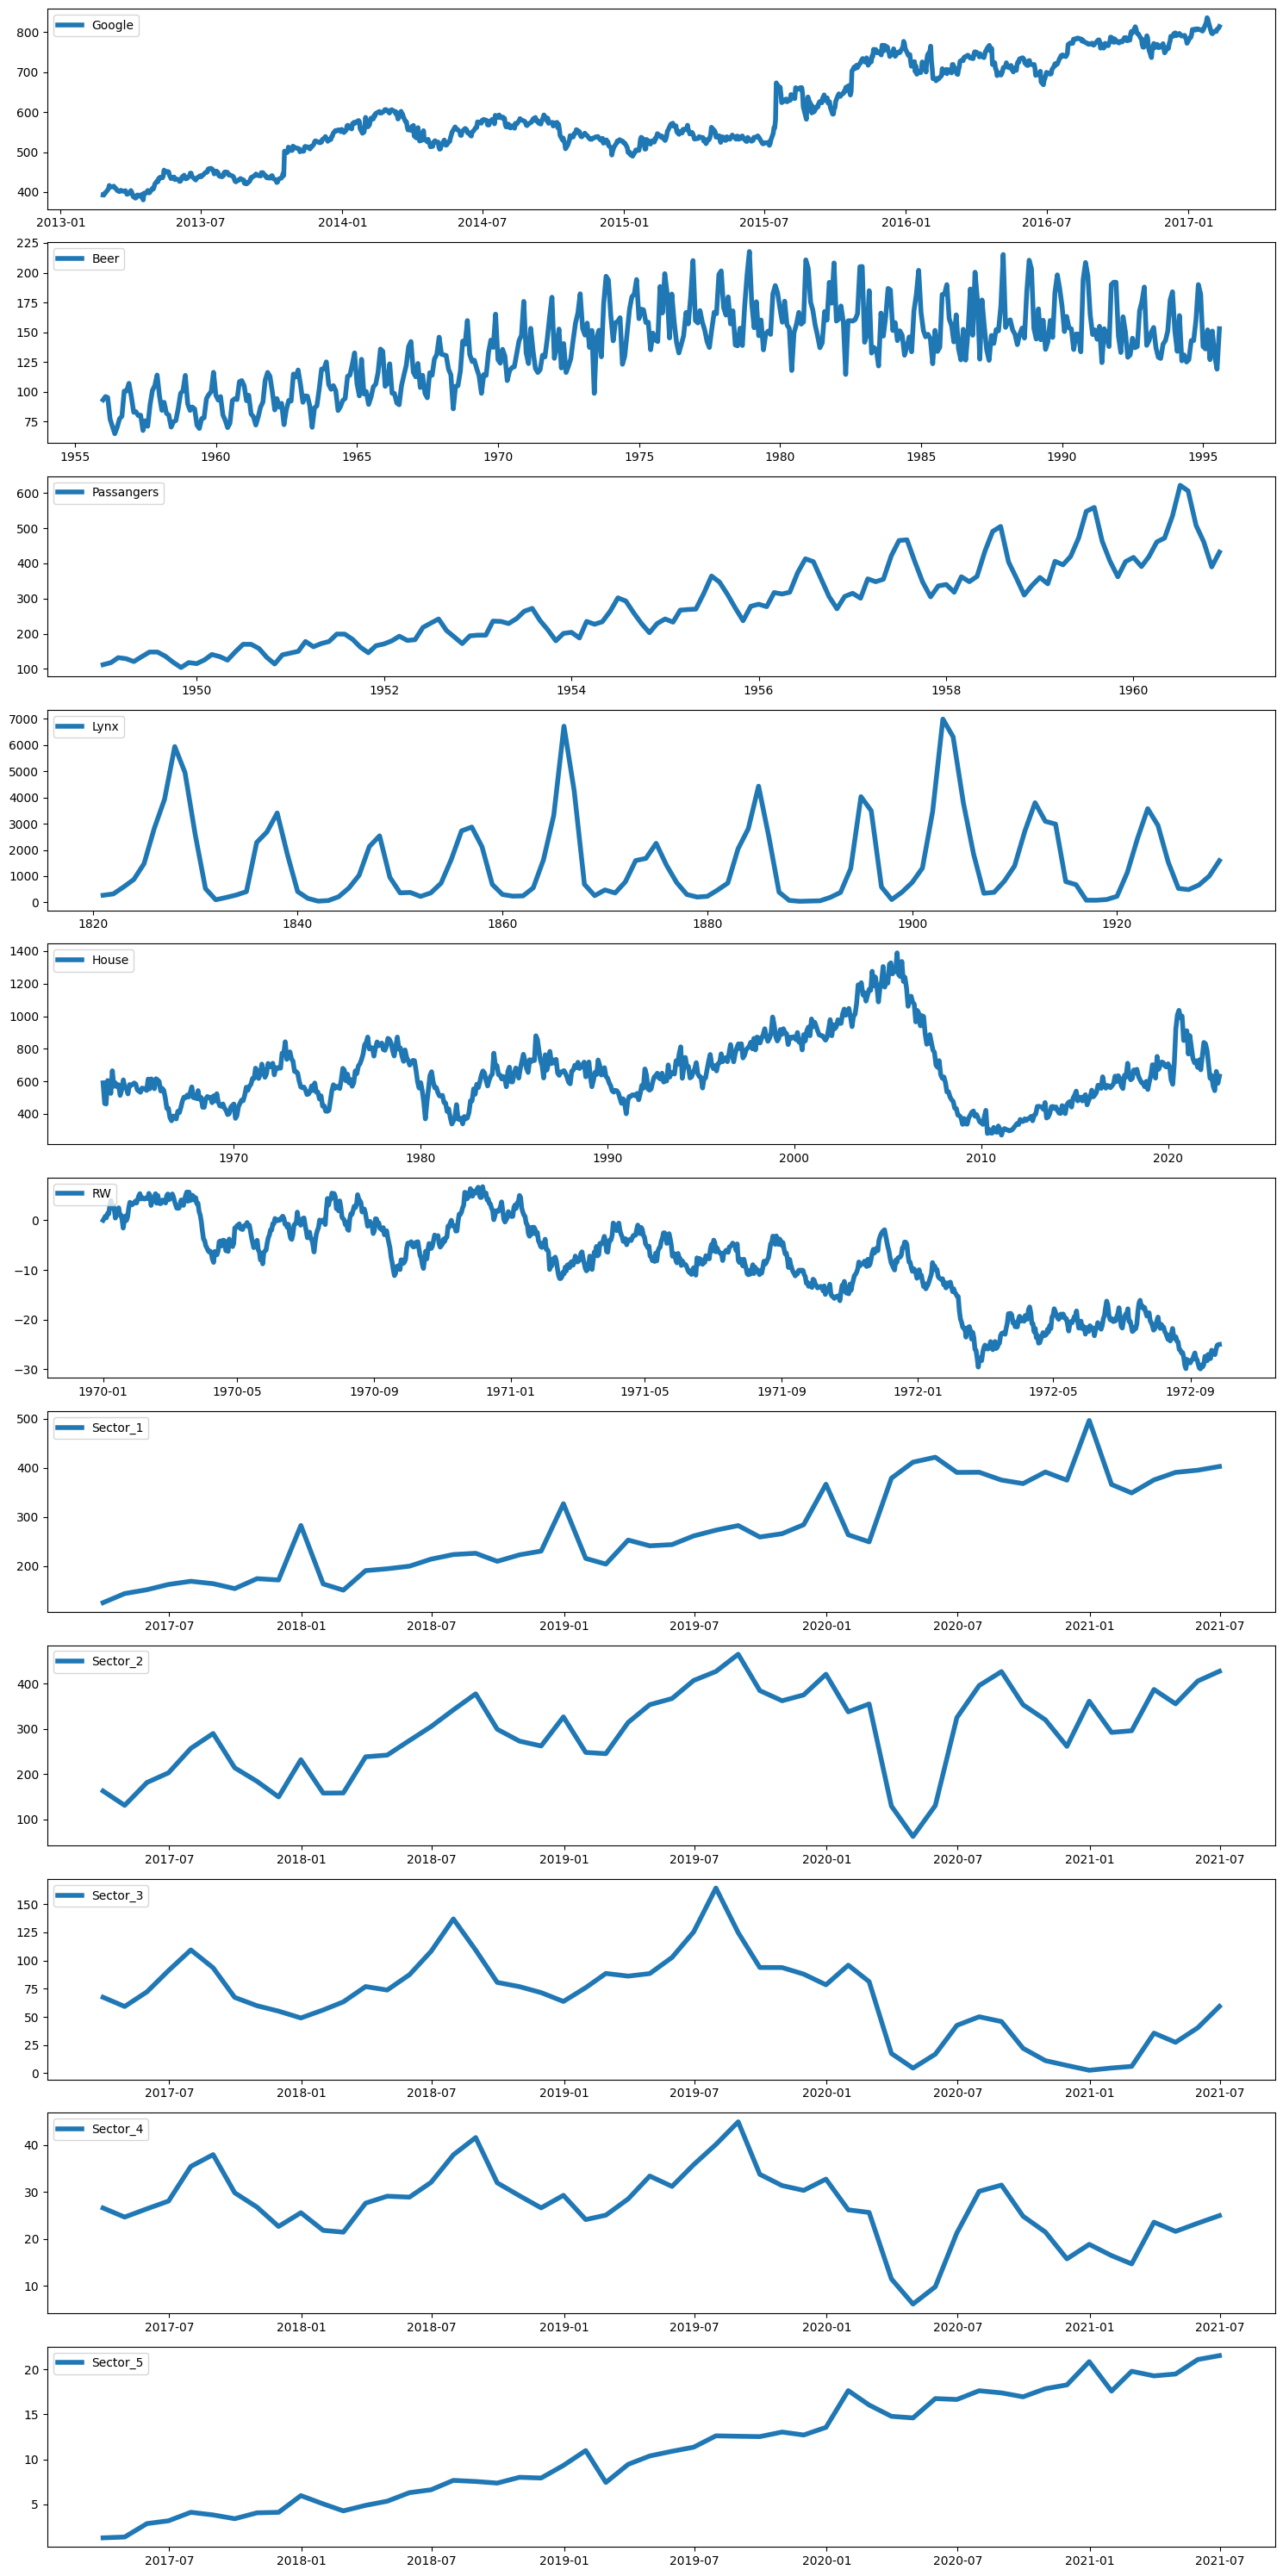

In [ ]:
plot_time_series(df = df, target_column = "y", fit_line = False)

---
### Pregunta 6: ¿Que STU son estacionarias?

<a id='transformaciones'></a>
# Transformaciones de STU (CORE IDEA)
[Volver al índice](#index)

A priori podría parecer que aplicar un modelo ARMA(pq) es tarea complicada por la exigencia de estacionariedad.

Y razón no faltaría porque es una condición exigente.

Ahora bien, podemos aplicar diferentes transformaciones sobre una serie temporal para convertirla en estacionaria.

Veremos sobre todo 2 transformaciones muy útiles:

1. Como podemos reducir la varianza de una STU **utilizando el logaritmo.**
2. Como podemos eliminar la tendencia de una STU **con la diferenciación.**

### (CORE IDEA) La diferenciación consiste en calcular cual es la variación de la serie temporal de un periodo a otro (hacer la resta de 2 valores en dos fechas consecutivas). Con esta técnica muy sencilla, eliminamos la tendencia de una serie temporal. Casi nunca hace falta hacer más de 2 diferenciaciones para conseguir una Serie Temporal Estacionaria.

In [ ]:
df["y_log"] = df["y"].apply(np.log1p)

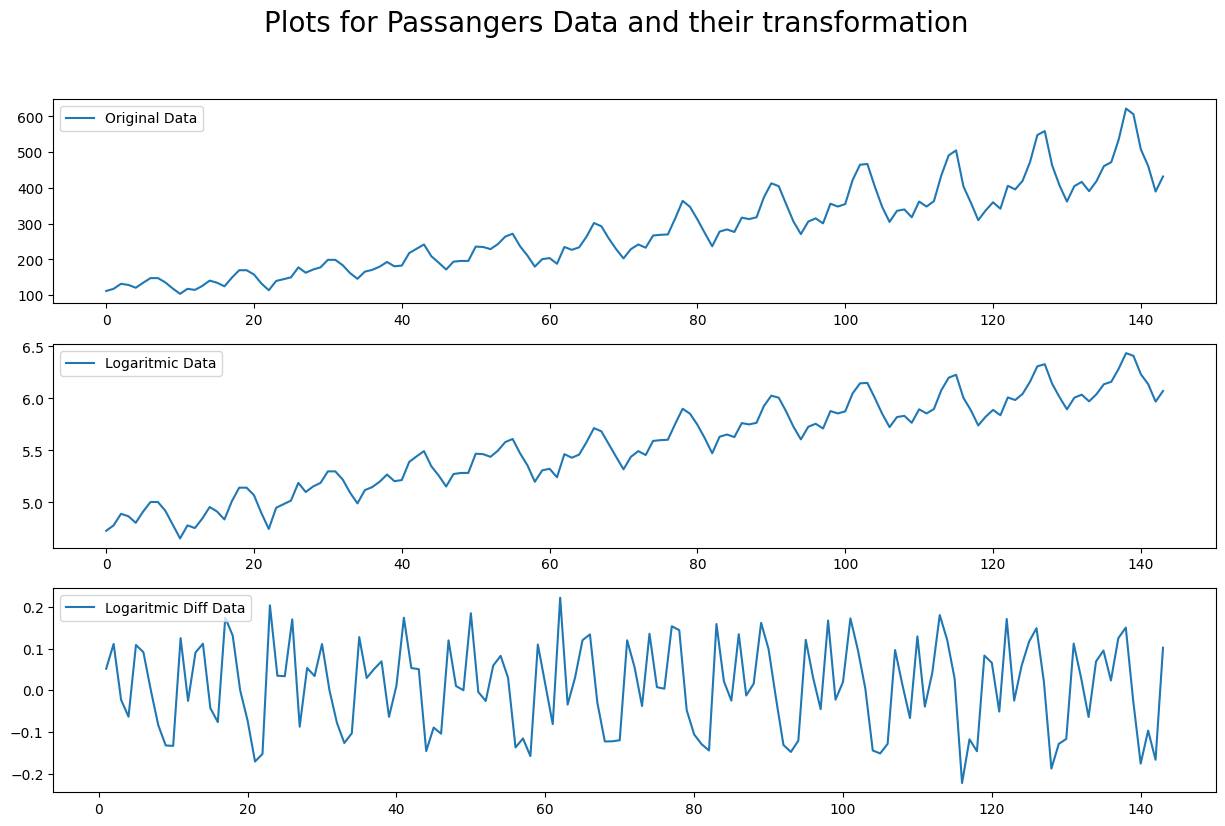

In [ ]:
# instanciate the figure
fig = plt.figure(figsize = (15, 9))
ax1, ax2, ax3 = fig.subplots(3, 1)

# select x and y to plot
ts_passangers = df[df["origin"] == "Passangers"][["ds", "y", "y_log"]]
ts_passangers["y_log_diff"] = ts_passangers["y_log"].diff()

# plotting part
ax1.plot(ts_passangers["y"], label = "Original Data")
ax2.plot(ts_passangers["y_log"], label = "Logaritmic Data")
ax3.plot(ts_passangers["y_log_diff"], label = "Logaritmic Diff Data")

ax1.legend(loc = "upper left")
ax2.legend(loc = "upper left")
ax3.legend(loc = "upper left")

fig.suptitle("Plots for Passangers Data and their transformation", fontsize = 20);

<a id='tests'></a>
# Tests Estadísticos para comprobar la estacionalidad
[Volver al índice](#index)

A veces es muy complicado evaluar visualmente si una serie temporal es o no estacionaria.

Por este motivo podemos ejecutar tests estadísticos para asegurarnos de que estamos en lo cierto.

Uno de los más frecuentes que se usa es el [Augmented Dickey–Fuller Test](https://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test).

La intuición detrás del test es que va a mirar si la STU tiene o no raíz unitaria.

En la práctica nos vamos a fijar en **p-valor** del test y si esta debajo de 0.05, la serie es estacionaria y podemos utilizar el enfoque ARMA(pq).

In [ ]:
for nombre_serie in df["origin"].unique():

    serie = df[df["origin"] == nombre_serie]["y"]

    print("------------------------------------------------------------------")

    print("Estamos trabajando con la serie {}\n".format(nombre_serie))
    resultado_analisis = adfuller(serie)

    valor_estadistico_adf = round(resultado_analisis[0], 3)
    p_valor = round(resultado_analisis[1], 3)

    print("Valor estadistico de ADF de las tablas precalculadas: {}".format(-2.89))
    print("Valor estadistico de ADF: {}\n".format(valor_estadistico_adf))

    print("Nivel de significación para tomar la serie como estacionaria {}".format(0.05))
    print("p-valor: {}\n".format(p_valor))


------------------------------------------------------------------
Estamos trabajando con la serie Beer

Valor estadistico de ADF de las tablas precalculadas: -2.89
Valor estadistico de ADF: -2.283

Nivel de significación para tomar la serie como estacionaria 0.05
p-valor: 0.178

------------------------------------------------------------------
Estamos trabajando con la serie Google

Valor estadistico de ADF de las tablas precalculadas: -2.89
Valor estadistico de ADF: -0.984

Nivel de significación para tomar la serie como estacionaria 0.05
p-valor: 0.759

------------------------------------------------------------------
Estamos trabajando con la serie House

Valor estadistico de ADF de las tablas precalculadas: -2.89
Valor estadistico de ADF: -3.15

Nivel de significación para tomar la serie como estacionaria 0.05
p-valor: 0.023

------------------------------------------------------------------
Estamos trabajando con la serie Lynx

Valor estadistico de ADF de las tablas precalculad

### Del ejemplo anterior, vemos que la STU de House y Lynx son estacionarias.

<a id='acf_pacf'></a>
# ACF y PACF de STU
[Volver al índice](#index)

Una vez que sabemos como podemos evaluar si una serie temporal es estacionaria o no (análisis visual o bien tests estadísticos), volvamos a nuestra Serie Temporal Univariante de Lynx.

In [ ]:
ts_lynx["y_log"] = ts_lynx["y"].apply(np.log1p)
ts_lynx["y_log_diff"] = ts_lynx["y_log"].diff()

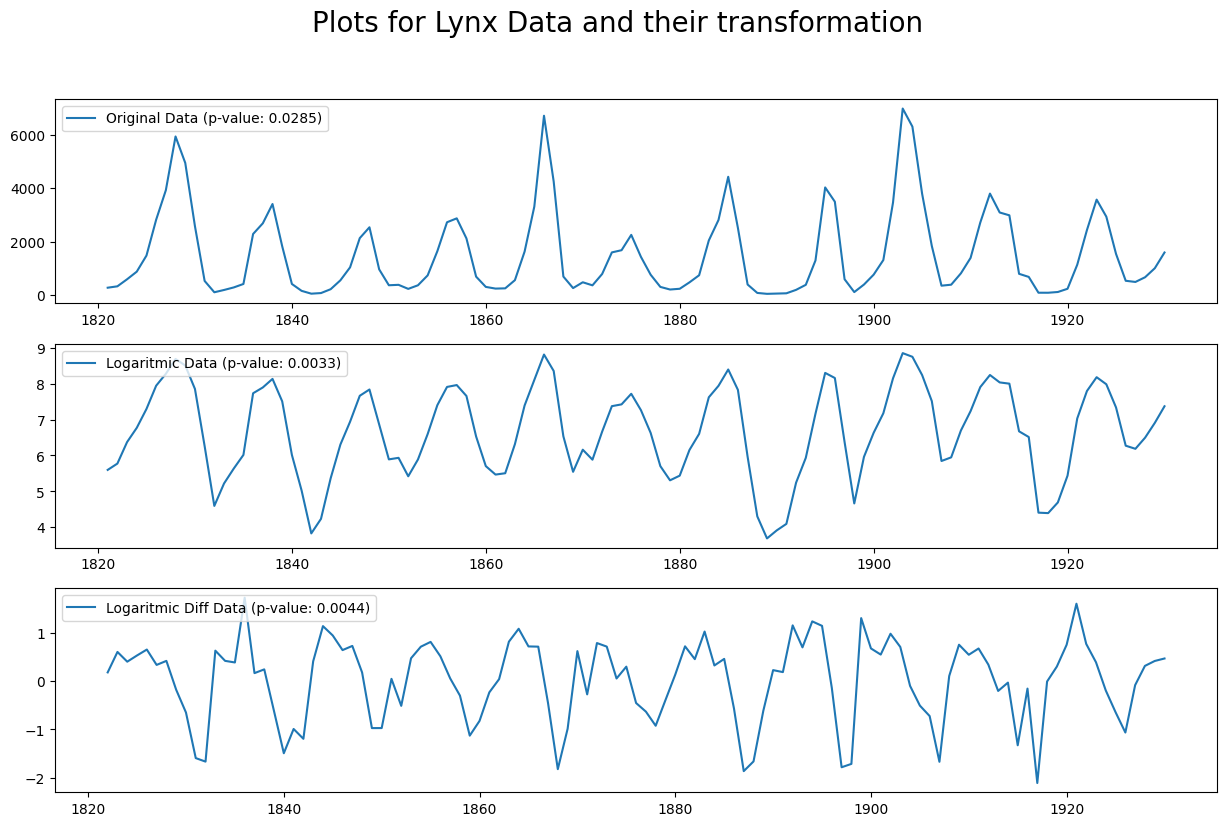

In [ ]:
# instanciate the figure
fig = plt.figure(figsize = (15, 9))
ax1, ax2, ax3 = fig.subplots(3, 1)

# select x and y to plot
xlynx = ts_lynx["ds"]

ylynx = ts_lynx["y"]
y_loglynx = ts_lynx["y_log"]
y_log_difflynx = ts_lynx["y_log_diff"]

# plotting part
ax1.plot(xlynx, ylynx, label = f"Original Data (p-value: {round(adfuller(ylynx)[1], 4)})")
ax2.plot(xlynx, y_loglynx, label = f"Logaritmic Data (p-value: {round(adfuller(y_loglynx)[1], 4)})")
ax3.plot(
    xlynx,
    y_log_difflynx,
    label = f"Logaritmic Diff Data (p-value: {round(adfuller(y_log_difflynx.dropna())[1], 4)})"
)

ax1.legend(loc = "upper left")
ax2.legend(loc = "upper left")
ax3.legend(loc = "upper left")

fig.suptitle("Plots for Lynx Data and their transformation", fontsize = 20);

### Del gráfico anterior se desprende que podríamos utilizar cualquier serie temporal para modelizar con el modelo de ARMA(pq) porque tanto la serie original y, como la y_log y la y_log_diff tienen un p-value < 0.05

Por tanto, ahora tenemos que contestar a la pregunta del millón:

### Pregunta 7: ¿Como puedo determinar los grados de mi modelo ARMA(pq)?

Vamos a utilizar 2 gráficos que nos serán de gran ayuda: ACF y PACF.

In [ ]:
y_log_difflynx.dropna(inplace = True)

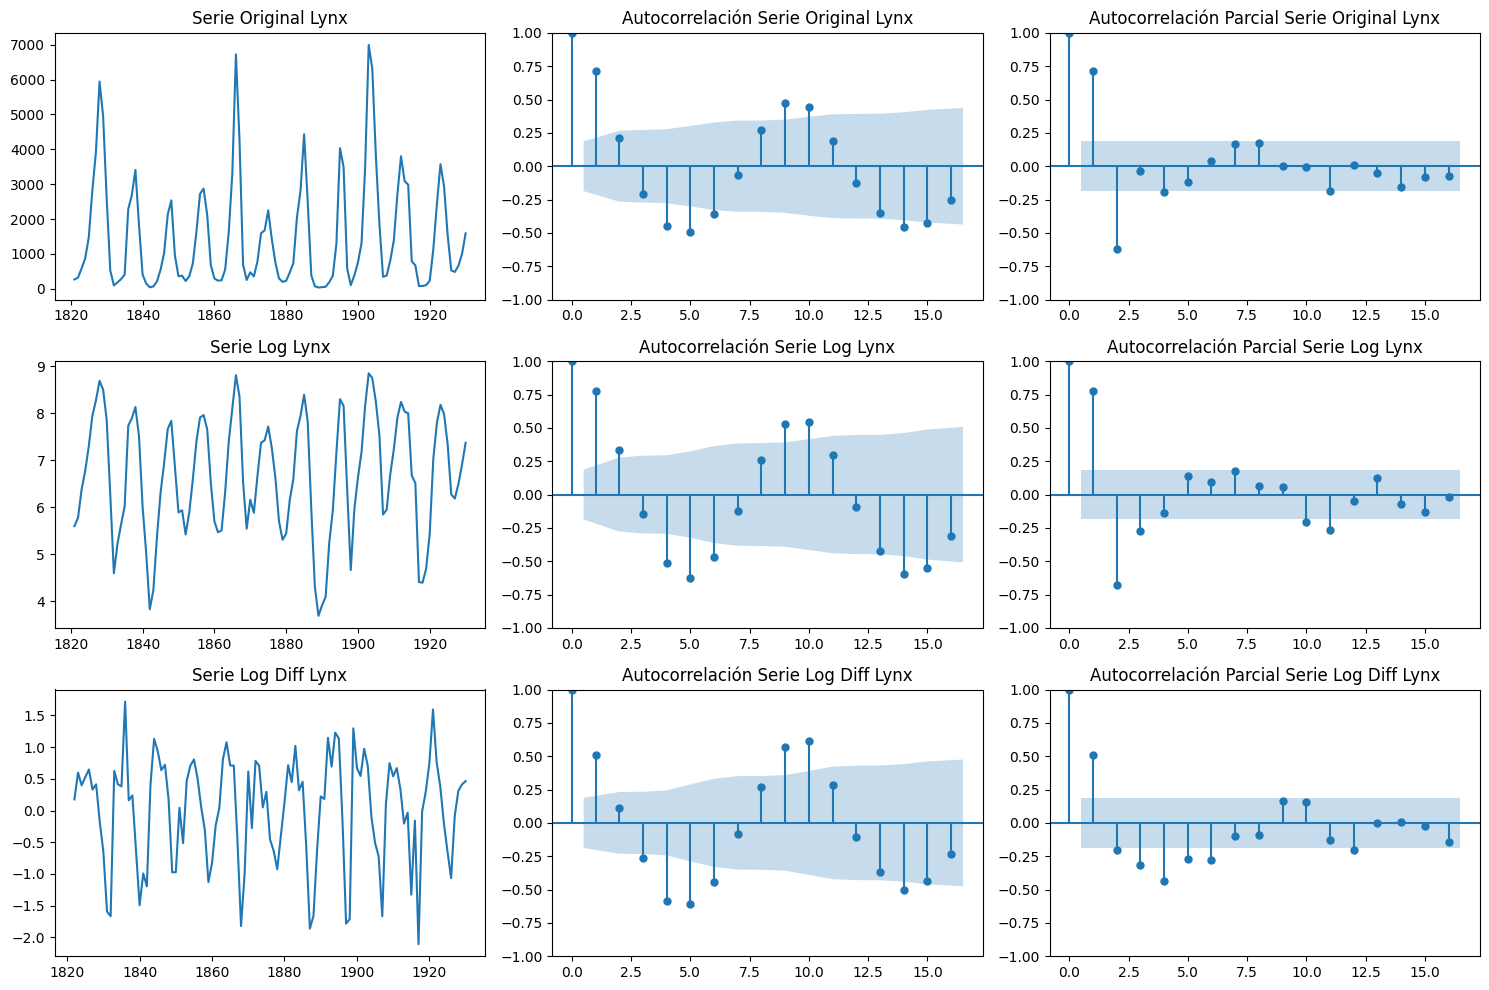

In [ ]:
LAGS = 16

fig = plt.figure(figsize = (15, 10))

((ax11, ax12, ax13), (ax21, ax22, ax23), (ax31, ax32, ax33)) = fig.subplots(3, 3)

ax11.plot(xlynx, ylynx)
ax11.set_title("Serie Original Lynx")
plot_acf(ylynx, ax = ax12, lags = LAGS, title = "Autocorrelación Serie Original Lynx")
plot_pacf(ylynx, ax = ax13, lags = LAGS, title = "Autocorrelación Parcial Serie Original Lynx")

ax21.plot(xlynx, y_loglynx)
ax21.set_title("Serie Log Lynx")
plot_acf(y_loglynx, ax = ax22, lags = LAGS, title = "Autocorrelación Serie Log Lynx")
plot_pacf(y_loglynx, ax = ax23, lags = LAGS, title = "Autocorrelación Parcial Serie Log Lynx")

ax31.plot(xlynx[1::], y_log_difflynx)
ax31.set_title("Serie Log Diff Lynx")
plot_acf(y_log_difflynx, ax = ax32, lags = LAGS, title = "Autocorrelación Serie Log Diff Lynx")
plot_pacf(y_log_difflynx, ax = ax33, lags = LAGS, title = "Autocorrelación Parcial Serie Log Diff Lynx")

fig.tight_layout()

¿Como puedo interpretar yo los dos gráficos anteriores?
1. **Gráfico de Autocorrelación:** muestra la correlación de Pearson entre la serie y la serie “laggeada” (valores anteriores de la serie). Este gráfico
nos permite determinar cuál es el grado q de la parte MA.
1. **Gráfico de Autocorrelación Parcial:** muestra la fuerza entre la serie y valores anteriores eliminando cualquier impacto intermedio.
Yt viene “influyenciado” por el valor en Yt-1, Yt-1 a su vez viene influyenciado por Yt-2. Por tanto, el gráfico de autocorrelación parcial viene a decir: que impacto tiene en Yt, Yt-2 si eliminamos el impacto en Yt de Yt-1. Por tanto vemos el impacto “directo” de Yt2 a Yt.

Los valores fuera del área sombreada son valores estadísticamente significativos y pueden servir para modelizar mi serie temporal.
En este momento del proceso de modelización “estamos acotando” posibles modelos que vamos a validar ya que a priori no sabemos cuál puede funcionar mejor.

In [ ]:
# correlación de pearson utilizando statsmodels
round(acf(x = ylynx)[1], 3)

0.717

In [ ]:
# correlación de pearson utilizando pandas
round(ts_lynx[["y", "y_ar_lag_1"]].corr(method = "pearson"), 3)

,y,y_ar_lag_1
y,1.000,0.719
y_ar_lag_1,0.719,1.000


Gracias a los gráficos ACF y PACF yo puedo "acotar" posibles modelos ARMA(pq).

Los posibles candidatos para mi STU Log Lynx serían:
1. ARMA(1, 1)
2. ARMA(1, 2)
3. ARMA(1, 3)
4. ARMA(2, 1)
5. ARMA(2, 2)
6. ARMA(2, 3)

### (CORE IDEA):

Ahora mismo estamos con la STU Log Lynx y buscamos determinar los grados del modelo ARMA(pq). <br>

#### ¿No obstante, que pasaría si queremos modelizar la STU Log Diff Lynx? Si recordabamos bien, la única diferencia entre Log Lynx y Log Diff Lynx es que hemos hecho una diferenciación. <br>

#### En los modelos ARMA(pq), si hacemos una diferenciación de una serie temporal para transformarla en estacionaria estamos introduciendo un nuevo parametro que es la I(d). <br>

#### De esta manera ARMA(pq) de Log Lynx Diferenciado es lo mismo que hacer ARIMA(pdq) sobre Log Lynx. <br>

Donde: <br> AR(p): es la parte autoregresiva del modelo <br> I(d): es el número de diferenciaciones que hemos hemos a la Serie Temporal. <br> MA(q): es la parte de medias móviles del modelo <br>

Ejemplo de lectura:
#### ARIMA(p = 2, d = 1, q = 0) de una serie temporal significa que la parte autoregresiva es 2, hemos hecho una diferenciación sobre la serie temporal y no tiene componente de medias móviles.

<a id='gridsearch'></a>
### Gridsearch de los parametros de un modelo ARIMA
[Volver al índice](#index)<br>

A continuación vamos a ver otra forma de calcular los **parametros de un modelo ARIMA(pdq)** utilizando "la fuerza bruta".

Aunque se trata de otra forma alternativa de hacerlo, recomendamos siempre utilizar tanto la ACF y PACF como el gridsearch a la hora de escoger los mejores parametros.

In [ ]:
ts_to_predict_arima = ts_lynx.set_index("ds")["y_log"]

In [ ]:
y_train_arima = ts_to_predict_arima[:-10]
y_test_arima = ts_to_predict_arima[-10:]

In [ ]:
pdq = [
    (1, 0, 1),
    (1, 0, 2),

    (2, 0, 1),
    (2, 0, 2),

    (1, 1, 1),
    (1, 1, 2),

    (2, 1, 1),
    (2, 1, 2)
]

seasonal_pdq = (0, 0, 0, 0)

In [ ]:
RESULTS_DICT = {}

for param in pdq:

    model = sm.tsa.statespace.SARIMAX(
        endog = y_train_arima,
        order = param,
        seasonal_order = seasonal_pdq,
        enforce_stationarity = False,
        enforce_invertibility = False
    )

    model_fitted = model.fit()

    print('ARIMA{}x{}12 - AIC:{}'.format(param, seasonal_pdq, model_fitted.aic))

    RESULTS_DICT[param] = round(model_fitted.aic, 2)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.11787D+00    |proj g|=  2.41751D-01

At iterate    5    f=  1.10356D+00    |proj g|=  2.84295D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      7     11      1     0     0   5.425D-07   1.104D+00
  F =   1.1035605239313409     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 0, 1)x(0, 0, 0, 0)12 - AIC:226.71210478626816
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N

/Users/nicolaepopescul/Desktop/code/venvs/env_main/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/Users/nicolaepopescul/Desktop/code/venvs/env_main/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/nicolaepopescul/Desktop/code/venvs/env_main/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/Users/nicolaepopescul/Desktop/code/venvs/env_main/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init

In [ ]:
# gridsearch x y gridsearch y
gsx = list(map(str, list(RESULTS_DICT.keys())))
gsy = list(RESULTS_DICT.values())

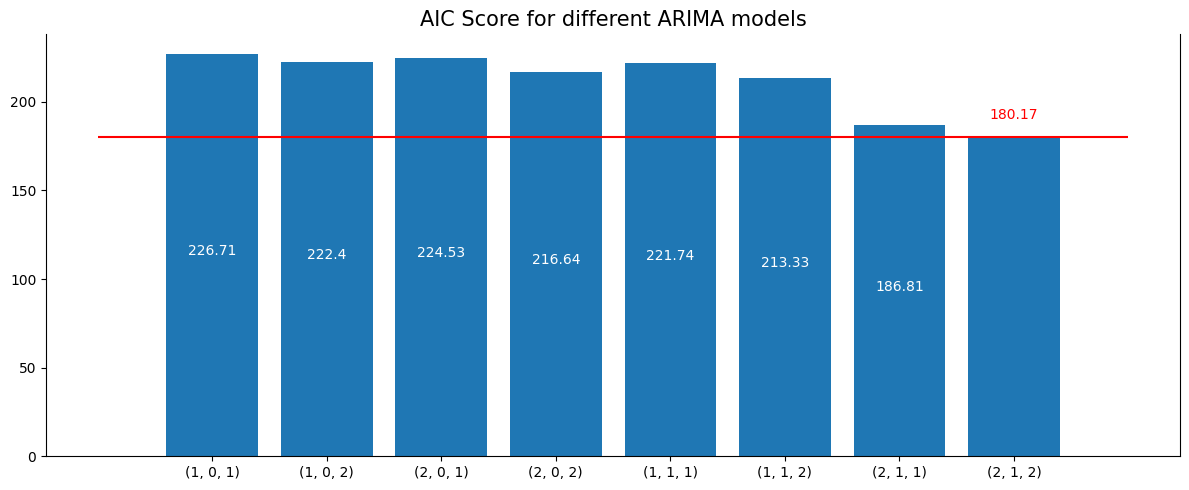

In [ ]:
fig = plt.figure(figsize = (12, 5))
ax = fig.add_subplot()

ax.bar(x = gsx, height = gsy)
ax.hlines(y = min(gsy), xmin = -1, xmax = len(gsx), color = "red")

for xtick_, y_ in zip(gsx, gsy):

    s_ = str(round(y_, 2))

    ax.text(
        x = xtick_,
        y = y_/2 if y_ != min(gsy) else y_ + 10,
        s = s_,
        ha = "center",
        color = "red" if y_ == min(gsy) else "white"
    )

ax.spines["top"].set_color("None")

plt.title(label = "AIC Score for different ARIMA models", fontsize = 15)
plt.tight_layout()

In [ ]:
idx_min_score_aic = np.argmin(list(RESULTS_DICT.values()))
pdq_min_score_aic = list(RESULTS_DICT.keys())[idx_min_score_aic]
min_score_aic = RESULTS_DICT[pdq_min_score_aic]

message = f'''
El score mínimo se alcanza con ARIMA{pdq_min_score_aic}
Con un score AIC de {min_score_aic}.
En la posición {idx_min_score_aic}
'''

print(message)


El score mínimo se alcanza con ARIMA(2, 1, 2)
Con un score AIC de 180.17.
En la posición 7



<a id='fit_arima'></a>
### Fit del modelo ARIMA(pdq)
[Volver al índice](#index)<br>

Vamos a hacer un recap de lo visto hasta ahora y de los pasos que nos quedan por implementar:

1. Partimos de una Serie Temporal Univariante.
2. Evaluamos si es estacionaria o no. Si no es estacionaria la serie temporal, hago las transformaciones pertinentes (log, diff u cualquier otra) para hacerla estacionaria.
3. Utilizo los gráficos de ACF y PACF para determinar los posibles grados del modelo ARIMA(pdq). En este paso, también puedo utilizar el Gridsearch junto con AIC para determinar los posibles parametros del modelo.

4. Una vez que tengo los grados del modelo, puedo pasar a estimar los coeficientes de mi modelo (phi y theta).

5. Posteriormente voy a evaluar la bondad de mi modelo (dataset de test o bien evaluar la distribución de los residuos del modelo).

6. Si el modelo es bueno, podré utilizarlo para hacer un forecasting.

Aunque de los 6 pasos hasta ahora sólo hemos visto los primeros 3, en realidad seguimos la metodología de [Box - Jenkins](https://en.wikipedia.org/wiki/Box%E2%80%93Jenkins_method) para trabajar con las TSU.

**Nota: El índice de AIC es Akaike Information Criterion y sirve para elegir un modelo entre un conjunto de posibles modelos. El índice calcula la distancia de Kullback - Leibler entre el modelo y la serie. Una forma de interpretar el índice es: buscamos el modelo con el menor índice porque es el modelo más simple y que ajusta bien a estos datos. El AIC es un indicador que penaliza modelos más complejos, porque en su cálculo intervienen el número de parametros del modelo. De esta manera, cumplimos con el principio de parsimonia: entre 2 modelos similares (en temas de performance) nos quedamos con el modelo más sencillo.**

In [ ]:
best_arima_model = sm.tsa.statespace.SARIMAX(
    endog = y_train_arima,
    order = pdq_min_score_aic,
    seasonal_order = seasonal_pdq,
    enforce_stationarity = False,
    enforce_invertibility = False
)

best_arima_model_fitted = best_arima_model.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.90311D-01    |proj g|=  5.74116D-01

At iterate    5    f=  8.70311D-01    |proj g|=  7.67156D-02

At iterate   10    f=  8.50852D-01    |proj g|=  1.22365D-02

At iterate   15    f=  8.50836D-01    |proj g|=  3.72311D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     15     19      1     0     0   3.723D-06   8.508D-01
  F =  0.85083559180455670     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/nicolaepopescul/Desktop/code/venvs/env_main/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/Users/nicolaepopescul/Desktop/code/venvs/env_main/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


In [ ]:
print(best_arima_model_fitted.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.4995      0.074     20.194      0.000       1.354       1.645
ar.L2         -0.8312      0.063    -13.112      0.000      -0.955      -0.707
ma.L1         -1.3359    100.595     -0.013      0.989    -198.498     195.827
ma.L2          0.3359     33.859      0.010      0.992     -66.026      66.698
sigma2         0.3290     33.051      0.010      0.992     -64.449      65.107


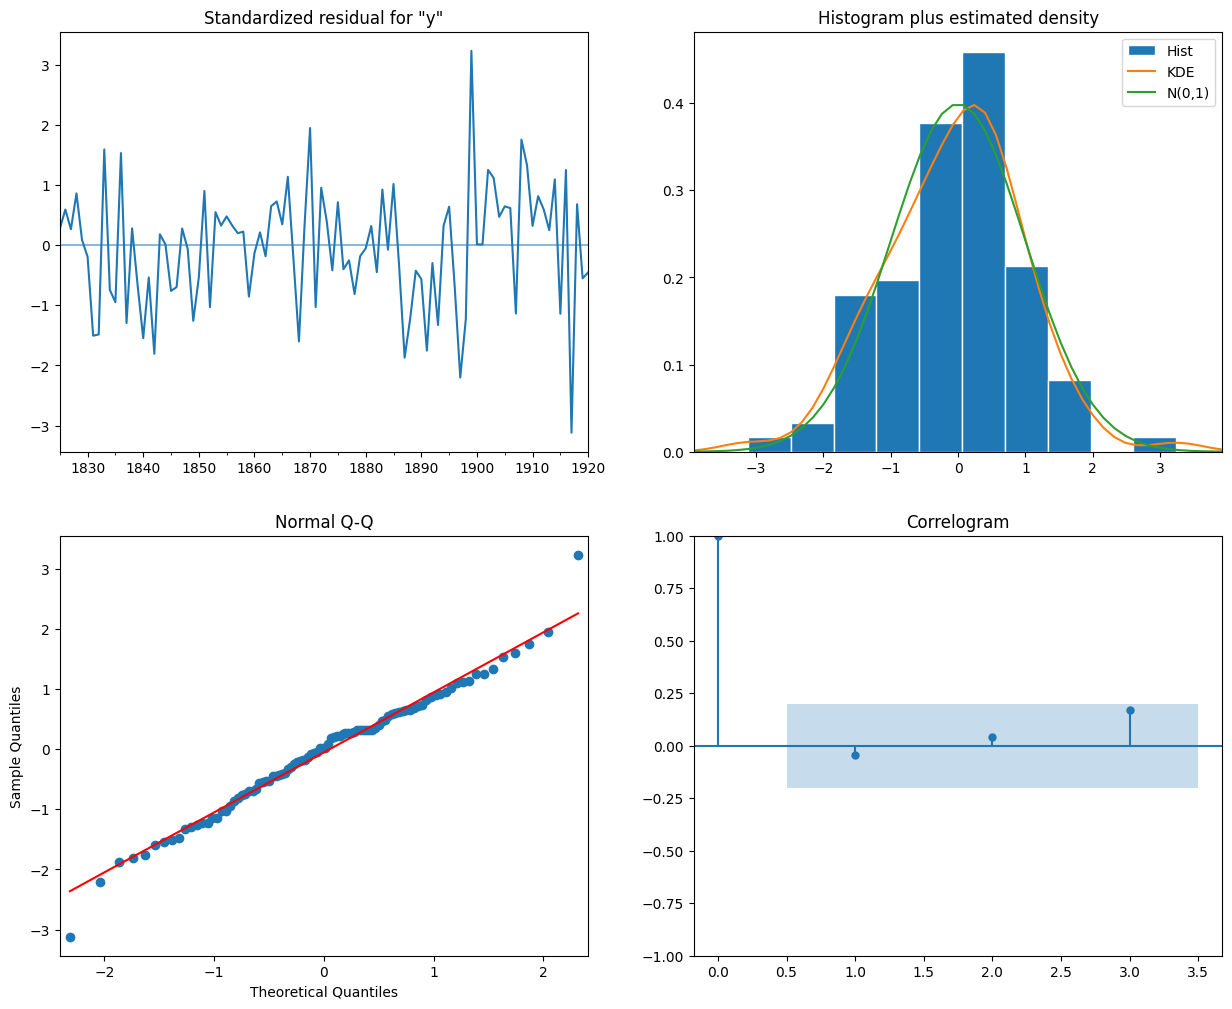

In [ ]:
best_arima_model_fitted.plot_diagnostics(figsize = (15, 12), lags = 3);

Mirando los gráficos podemos observar lo siguiente:

**Arriba a la izquiera:** los residuos del modelo parece que siguen un proceso de Ruido Blanco (White Noise) y no son predecibles. Esto implica que nuestro modelo ha extraído toda la información de los datos.<br>
**Arriba a la derecha:** vemos que la distribución de los residuos sigue una distribución próxima a la Normal (0, 1).<br>
**Abajo a la derecha:** vemos que la autocorrelación parcial entre los residuos y residuos - k periodos atrás, dan lugar a valores no significativos. Esto implica que no "nos queda" información a extraer de los residuos.<br>
**Abajo a la izquierda:** la distribución ordenada de los residuos sigue una Normal.<br>

In [ ]:
# Para hacer una predicción es suficiente con especificar el número de steps/pasos futuros a estimar.
pred_uc = best_arima_model_fitted.get_forecast(steps = len(y_test_arima))
y_pred_arima = pred_uc.predicted_mean

In [ ]:
y_pred_arima

1921-01-01    6.550584
1922-01-01    7.511610
1923-01-01    8.027980
1924-01-01    8.003483
1925-01-01    7.537538
1926-01-01    6.859200
1927-01-01    6.229305
1928-01-01    5.848594
1929-01-01    5.801279
1930-01-01    6.046777
Freq: YS-JAN, Name: predicted_mean, dtype: float64

Text(0.5, 0.98, 'Lynx Values and ARIMA Forecast')

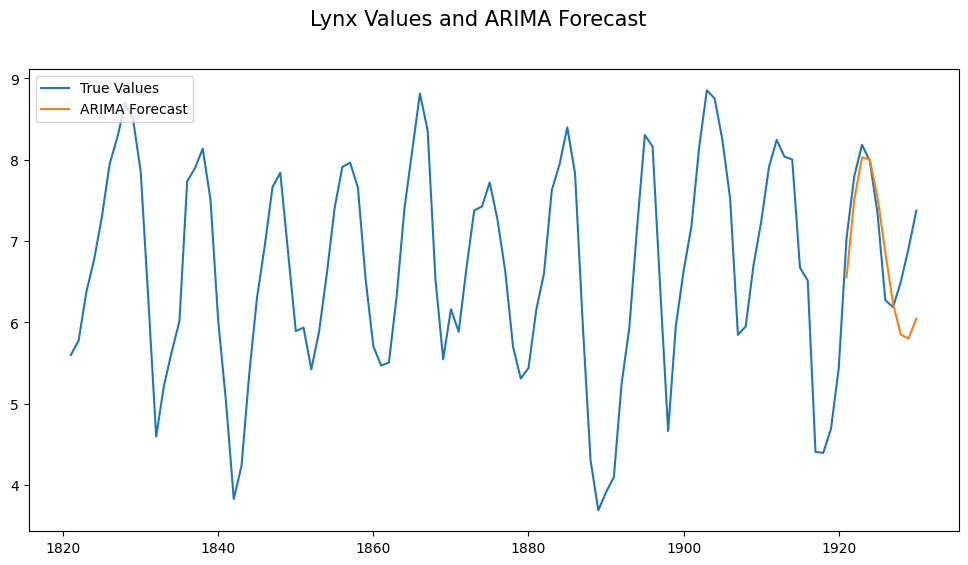

In [ ]:
fig = plt.figure(figsize = (12, 6))
ax = fig.subplots()

ax.plot(ts_to_predict_arima, label = "True Values")
ax.plot(y_pred_arima, label = "ARIMA Forecast")

ax.legend(loc = "upper left")
fig.suptitle("Lynx Values and ARIMA Forecast", fontsize = 15)

<a id='prophet'></a>
### Prophet
[Volver al índice](#index)<br>

Hasta ahora hemos explorado los modelos ARIMA(pdq) y la metodología de Box - Jenkins para trabajar con las Series Temporales.

No obstante, existen otras formas de enfocar la modelización de una TSU.

En las siguientes secciones iremos viendo algunas de estas técnicas y vamos a empezar por el algoritmo de Prophet.

[Prophet](https://facebook.github.io/prophet/docs/quick_start.html) es una algoritmo desarrollado por la compañia Meta (antiguo Facebook) y publicado en el año [2017](https://peerj.com/preprints/3190/).

**Según los autores del paquete, es la herramienta que utilizan internamente para hacer los forecastings diarios a escala.**

Antes de ver el uso del algoritmo, merece la pena hacer una breve parada y hacer la siguiente reflexión.

Según la teoría de las Series Temporales, cualquier STU se puede descomponer en 3 elementos:
1. **Trend**: la tendecia a largo plazo. Hacia donde tiende la Serie Temporal.
2. **Seasonal**: la parte más estacional de una Serie Temporal. Por ejemplo: la demanda en los bares es más grande durante el fin de semana que el resto de la semana. Este patrón se repite cada semana durante el año (aunque en verano es más alta que en invierno).
3. **Residual**: la parte residual que no se recoge en los dos puntos anteriores.

A continuación vamos a utilizar statsmodels para descomponer una serie temporal.

In [ ]:
def decompose_ts(ts_to_decompose, period, title):
    '''
    Uses seasonal_decompose from statsmodels to decompose a ts.
    Plots the results on 4 differents plots.
    '''

    # decompose the series using stats module
    # results in this case is a special class
    # whose attributes we can acess
    result = seasonal_decompose(ts_to_decompose, period = period)

    # ----------------------------------------------------------------------------------------------------
    # instanciate the figure
    # make the subplots share teh x axis
    fig, axes = plt.subplots(ncols = 1, nrows = 4, sharex = True, figsize = (10, 6))

    # ----------------------------------------------------------------------------------------------------
    # plot the data

    # plot the original data
    result.observed.plot(ax = axes[0], legend = False)
    axes[0].set_ylabel('Observed')
    axes[0].set_title(title)

    # plot the trend
    result.trend.plot(ax = axes[1], legend = False)
    axes[1].set_ylabel('Trend')

    # plot the seasonal part
    result.seasonal.plot(ax = axes[2], legend = False)
    axes[2].set_ylabel('Seasonal')

    # plot the residual
    result.resid.plot(ax = axes[3], legend = False)
    axes[3].set_ylabel('Residual');

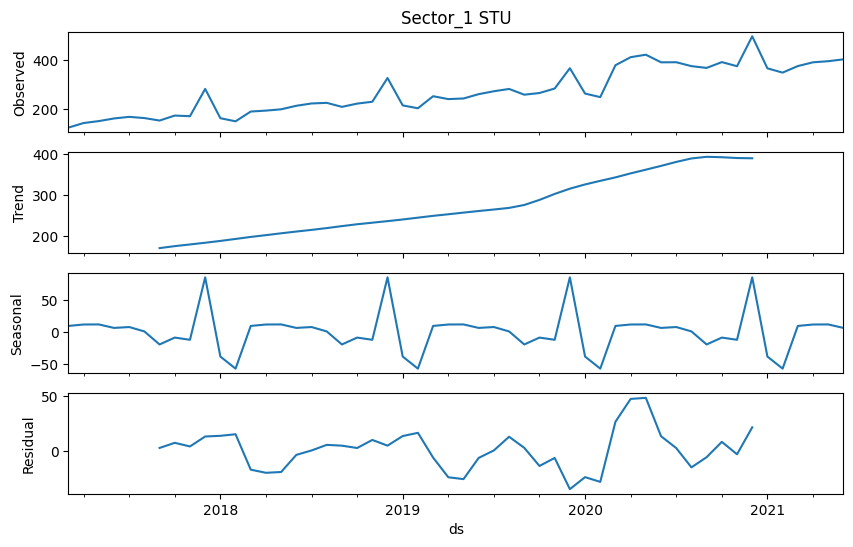

In [ ]:
ts_sector_1 = df[df["origin"] == "Sector_1"][["ds", "y"]]
ts_sector_1.set_index("ds", inplace = True)

# para utilizar seasonal_decompose, debemos pasarle un pandas series con ds (fecha) en el índice
decompose_ts(ts_to_decompose = ts_sector_1, period = 12, title = "Sector_1 STU")

Una vez que tenemos este conocimiento, puede surgir la siguiente pregunta:
**¿No sería interesante desgranar la Serie Temporal en los 3 componentes y posteriormente entrar un modelo para cada uno? De esta manera tenemos modelos más robustos para el Trend y Seasonal y la predicción final es la suma de las 2 predicciones y el residual (se le puede agregar ruido de un proceso gausiano).**

Justamente esto es lo que busca hacer Prophet.

Es un **modelo aditivo** y que busca tener buenos resultados **"out of the box"**, sin necesidad de hacer mucho tunning.

La formula matemática que describe el modelo Prophet es la siguiente:

**yt = g(t) + s(t) + h(t) + εt**

Donde:

**yt:** es la serie temporal que queremos predecir.<br>
**g(t):** es el trend de la serie temporal.<br>
**s(t):** es la parte estacional de la serie temporal. Patrones que se repiten cada n periodos.<br>
**h(t):** es la parte encargada de capturar los efectos de los días festivos.<br>
**εt:** es el ruido del modelo.<br>

Veamos a continuación como podemos utilizar este algoritmo para una STU.

In [ ]:
# el único requisito del algoritmo prophet es que el input sea un df y que tenga 2 columnas:
# ds la columna de tiempo
# y la columna con la cantidad
ts_prophet = df[df["origin"] == "Sector_1"][["ds", "y"]]

# instaciamos el modelo
prophet = Prophet()

# entrenamos nuestro modelo
prophet.fit(ts_prophet)

# preparamos un df para la predicción futura
# prophet nos da la función auxiliar de make_future_dataframe
# que permite generar automáticamente los periodos necesarios para el forecast futuro
future_df = prophet.make_future_dataframe(periods = 12, freq = "M", include_history = True)

# hacemos la predicción
y_pred_prophet = prophet.predict(future_df)

17:08:06 - cmdstanpy - INFO - Chain [1] start processing
17:08:06 - cmdstanpy - INFO - Chain [1] done processing


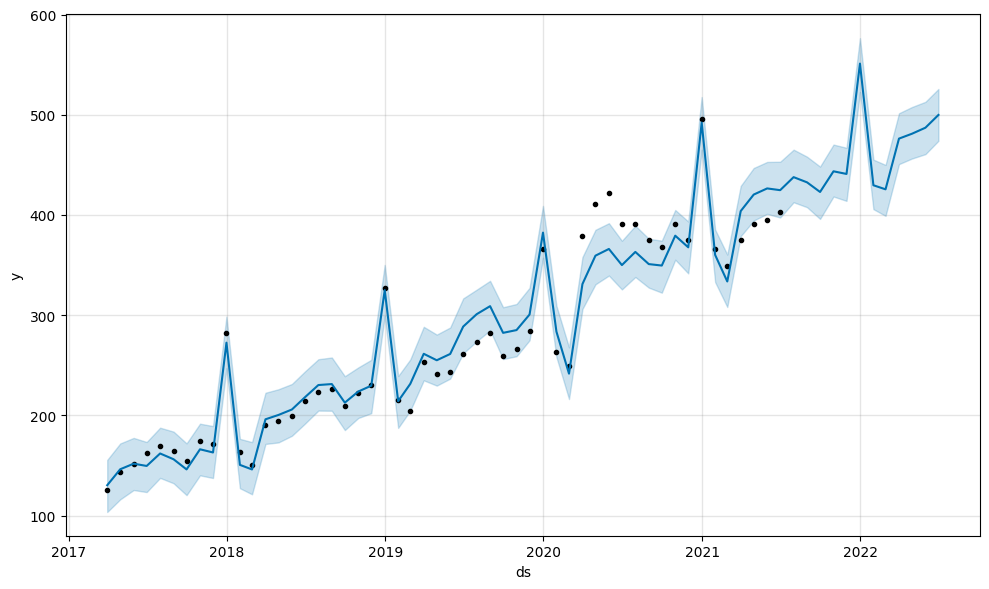

In [ ]:
# usamos las herramientas internas de prophet para plottear los resultados
prophet.plot(y_pred_prophet);

### Prophet es un buen algoritmo de partida y un buen benchmark para Series Temporales con datos agregados o bien para datos económicos y/o de negocio (con patrones que se repiten, tendencia clara, fuerte actividad en los festivos).

<a id='holt_winters'></a>
### Holt Winters (BONUS)
[Volver al índice](#index)<br>

**Holt Winters** es otro de los métodos clásicos para hacer forecasting de Series Temporales.

Fue desarrollado por [Charles Holt](https://en.wikipedia.org/wiki/Charles_C._Holt) en los 50 (**Doble Exponential Smoothing**). En 1960 Peter Winters (un ex alumno de Holt) amplia el método a **Triple Exponential Smoothing** o el método Holt Winters.

Para comprender cual es la idea básica de este método, vamos a implementar el método de manera autónoma y posteriormente daremos la fórmula matemática.

Trabajaremos con la Serie Temporal Sector_1.

In [ ]:
# lo convertimos en una lista
ts_sector_1_list = ts_sector_1["y"].tolist()

In [ ]:
print(str(ts_sector_1_list[:2]), "..." + str(ts_sector_1_list[-2:]))

[125.4172818923455, 143.9380108899385] ...[395.0426052412139, 402.5360888282046]


Hemos comentado antes, que el forecasting más **naive** es suponer que mañana pasará lo mismo que hoy. **Por tanto, vamos a predecir el último valor observado.**

In [ ]:
def naive_forecast(series):
    '''
    Implements the naive forecasting method.
    '''
    return series[-1]

In [ ]:
naive_forecast(series = ts_sector_1_list)

402.5360888282046

El método anterior no tiene en cuenta toda la información de toda la serie temporal.

Otra forma algo mejor es calcular la **media histórica** de la serie y predecir siempre esta media.

In [ ]:
def average_forecast(series):
    '''
    Implements the average forecasting method.
    '''
    return np.mean(series)

In [ ]:
average_forecast(series = ts_sector_1_list)

272.8557012631103

Ahora bien a la hora de predecir la media, todos los valores de la serie temporal se van a tener en cuenta. Alguno se puede preguntar:

**¿No sería más preciso que sólo tengamos en cuenta los valores más recientes?**

Si este es vuestro caso, podemos implementar **una media móvil.**

In [ ]:
def moving_average_forecast(series, window):
    '''
    Implements the moving average forecasting method.
    '''
    return np.mean(series[-window:])

In [ ]:
moving_average_forecast(series = ts_sector_1_list, window = 3)

396.0382678639001

¿Que otra cosa nos queda para mejorar la predicción anterior?

En vez de dar la misma importancia a los valores que intervienen en la media móvil, **¿no sería mejor darles diferente peso a cada valor?**

En este caso estaríamos hablando de una **media móvil ponderada.**

In [ ]:
def weighted_moving_average_forecast(series, weights):
    '''
    Implements the weighted moving average forecasting method.
    '''
    assert np.sum(np.array(weights)) == 1, f"Weights must add to 1. The actual sum is {round(np.sum(weights), 2)}"

    return sum(np.array(series[-len(weights):]) * np.array(weights))

In [ ]:
# la suma de los pesos debe dar igual a 1, en caso contrario podemos tener resultados raros
weights = [0.1, 0.2, 0.3, 0.4]
weighted_moving_average_forecast(series = ts_sector_1_list, weights = weights)

395.15916671904336

Si hacemos una recapitulación de los pasos anteriores tenemos lo siguiente:

1. Hay métodos que usan toda la serie temporal (por ejemplo: la media) o bien sólo algunos valores (por ejemplo: naive forecast o bien las medias móviles).

2. Hay métodos que dan la misma importancia a algunos valores (por ejemplo: la media móvil) y omiten el resto.

**Podemos hacer algo intermedio, usar TODOS los valores de la Serie Temporal pero asignar DIFERENTES pesos a cada valor. De tal manera que los valores más reciente tienen mayor peso y los más antiguos menor peso.**

**Este método se llama Exponential Smoothing y viene definido por la siguiente expresión:**

## 𝑦̂𝑥 = 𝛼⋅𝑦𝑥+(1−𝛼)⋅𝑦̂𝑥−1

Donde:

**𝑦̂𝑥**: es nuestra estimación para el periodo x.

**𝛼**: alpha es el coeficiente modelo y viene a ser el peso que le vamos a dar cada valor.

**𝑦𝑥**: es el valor observado en el periodo x.

**𝑦̂𝑥-1**: es l aestimación para el periodo x - 1

**Si nos fijamos de manera detenida en la fórmula anterior vemos que es recursiva. Es decir, 𝑦̂𝑥 depende en (1 - 𝛼) de 𝑦̂𝑥-1. 𝑦̂𝑥-1 a su vez depende de 𝑦̂𝑥-2. Además, según esta ecuación, conforme más nos alejammos al pasado, menos influencia van a tener estos valores.**

**Por tanto, si alpha es elevado: los valores del presente van a tener mayor importancia y viceversa.**

Veamos una implementación manual:

In [ ]:
def simple_exponential_smoothing_forecast(series, alpha):
    '''
    Implements the simple exponential smoothing forecasting method.
    '''
    result = [series[0]] # creamos una lista vacía

    for value in series[1:]:
        result.append((alpha * value) + ((1 - alpha) * result[-1]))

    return result

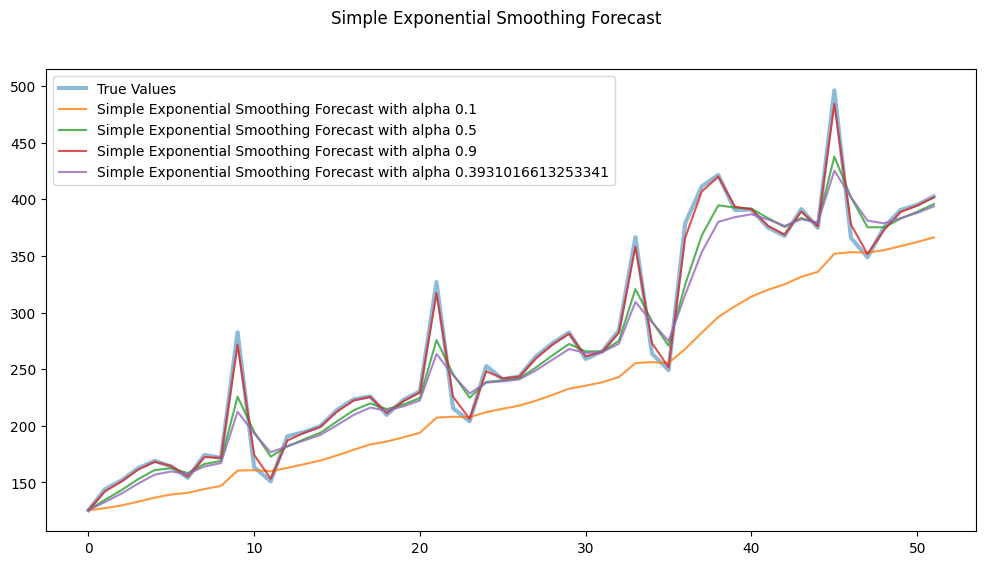

In [ ]:
fig = plt.figure(figsize = (12, 6))
ax = fig.add_subplot()

ax.plot(range(len(ts_sector_1_list)), ts_sector_1_list, label = "True Values", lw = 3, alpha = 0.5)

for alpha in [.1, .5, .9, 0.3931016613253341]:

    ses_predict = simple_exponential_smoothing_forecast(series = ts_sector_1_list, alpha = alpha)

    ax.plot(
        range(len(ts_sector_1_list)),
        ses_predict,
        label = f"Simple Exponential Smoothing Forecast with alpha {alpha}",
        lw = 1.5,
        alpha = .8
    )

fig.suptitle("Simple Exponential Smoothing Forecast")
plt.legend();

In [ ]:
sem = SimpleExpSmoothing(endog = ts_sector_1_list)
sem_fitted = sem.fit()
sem_fitted.params

{'smoothing_level': 0.40228933691681096,
 'smoothing_trend': nan,
 'smoothing_seasonal': nan,
 'damping_trend': nan,
 'initial_level': 125.4172818923455,
 'initial_trend': nan,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [ ]:
# montamos un df de comparativa

index_ses = ["Estimación Inicial"] + list(range(1, len(ts_sector_1_list) + 1))

manual_ses = pd.Series(data = [0] + ses_predict, index = index_ses, name = "Manual")

statsmodels_ses = pd.Series(
    data = list(sem_fitted.fittedvalues) + list(sem_fitted.forecast(1)),
    index = index_ses,
    name = "Statsmodel"
)

original_values = pd.Series(data = [0] + ts_sector_1_list, index = index_ses, name = "Original")

ses_df = pd.concat([manual_ses, statsmodels_ses, original_values], axis = 1)
ses_df["Diff Manual vs Statsmodel"] = ses_df["Manual"] - ses_df["Statsmodel"]
ses_df["Diff Manual vs Original"] = ses_df["Manual"] - ses_df["Original"]
ses_df["Diff Statsmodel vs Original"] = ses_df["Statsmodel"] - ses_df["Original"]
ses_df.applymap(lambda num: round(num, 2))

,Manual,Statsmodel,Original,Diff Manual vs Statsmodel,Diff Manual vs Original,Diff Statsmodel vs Original
Estimación Inicial,0.00,125.42,0.00,-125.42,0.00,125.42
1,125.42,125.42,125.42,0.00,0.00,0.00
2,132.70,132.87,143.94,-0.17,-11.24,-11.07
3,140.20,140.48,151.78,-0.28,-11.58,-11.31
4,148.97,149.34,162.51,-0.37,-13.54,-13.17
5,156.84,157.25,169.00,-0.41,-12.15,-11.75
6,159.69,160.00,164.09,-0.31,-4.40,-4.09
7,157.47,157.61,154.05,-0.13,3.42,3.56
8,164.08,164.31,174.28,-0.23,-10.20,-9.97
9,167.05,167.26,171.63,-0.21,-4.59,-4.38


Según el método de Exponential Smoothing, la predicción a futuro **SIEMPRE** será el valor **393.69**. Igual que el valor que nos sale en el método manual.

In [ ]:
sem_fitted.forecast(steps = 3)

array([393.86530027, 393.86530027, 393.86530027])

Una par de notas sobre nuestro df comparativo.

Vemos que hay una diferencia en la Estimación Inicial. Según la implementación manual, no hay ningun valor y en cambio en Statsmodel sale 142.99.

Este valor es el resultado de optimizar la siguiente expresión:

![SES_INITIAL_VALUE](pictures/SES_INITIAL_VALUE.png)

**Es decir, es el valor que minimiza los errores que salen de nuestro forecast y los valores observados.**

No obstante, vemos que esto no afecta a la predicción final y que conforme avanzamos en la TS, la diferencia entre las dos implementaciones se reduce.

Hay otra cosa que podemos hacer para mejorar la predicción anterior.

Sabemos que las Series Temporales pueden presentar un trend (una tendencia a largo) o bien pueden presentar un patrón periódico (seasonal). ¿Podemos incorporar esto en nuestro forecasting?

La respuesta es sí y se llama **Double Exponential Smoothing (DES)** y **Triple Exponential Smoothing (TES) (o Holt Winters)**.

Empecemos por el DES:

## Value = ℓ𝑥 = 𝛼𝑦𝑥+(1−𝛼)(ℓ𝑥−1+𝑇𝑥−1)
## Trend = 𝑇𝑥 = 𝛽(ℓ𝑥−ℓ𝑥−1)+(1−𝛽)𝑇𝑥−1 x
## Forecast = 𝑦̂𝑥+1= ℓ𝑥 + 𝑇𝑥

𝑦̂𝑥+1 es el resultado de Value (de hecho en Simple Exponential Smoothing es el 𝑦̂𝑥, pero ahora no podemos llamarlo 𝑦̂𝑥 porque habitualmente 𝑦̂𝑥 se reserva a las predicciones y Value es un input del Forecast) y Trend.

In [ ]:
def double_exponential_smoothing_forecast(series, alpha, beta, n_preds):
    '''
    Implements the double exponential smoothing forecast
    '''
    len_series = len(series)

    level = series[0] # primera predicción es el primer valor de la ts
    trend = series[1] - level # pendiente de la serie temporal (diff entre los dos primeros puntos observados)

    result = [level] # creamos una lista con nuestros futuros forecasts

    for i in range(1, len_series + 1): # + 1 para llegar al final de nuestro serie temporal

        if i < len_series: # mientras ajustamos la serie "real"
            value = series[i]

        else:
            # cuando vamos a querer hacer el forecasting, el value será nuestro último ajuste a la serie real
            value = result[-1]

        # hacemos el swap
        previous_level = level
        level = ((alpha * value) + ((1 - alpha) * (level + trend)))

        trend = ((beta * (level - previous_level)) + ((1 - beta) * trend))

        yhat = round((level + trend), 3)

        result.append(yhat)

    # la predicción a futuro
    if n_preds > 1:
        for n_pred in range(2, n_preds + 1):
            yhat = round((level + (n_pred * trend)), 3)
            result.append(yhat)

    return result

In [ ]:
manual_des = double_exponential_smoothing_forecast(
    series = ts_sector_1_list,
    alpha = 0.9,
    beta = 0.9,
    n_preds = 12
)

Antes de ver los resultados de DES, veamos la formula del método de Holt Winters (TES).

Se trata de ampliar la formula anterior añadiendo la parte de Seasonal a la ecuación.

### Level = ℓ𝑥 = 𝛼(𝑦𝑥−𝑆𝑥−𝐿)+(1−𝛼)(ℓ𝑥−1+𝑇𝑥−1)

### Trend = 𝑇𝑥 = 𝛽(ℓ𝑥−ℓ𝑥−1)+(1−𝛽)𝑇𝑥−1

### Seasonal  = 𝑆𝑥 = 𝛾(𝑦𝑥−ℓ𝑥)+(1−𝛾)𝑠𝑥−𝐿

### Forecast = 𝑦̂𝑥+𝑚= ℓ𝑥+𝑚𝑇𝑥+𝑆𝑥−𝐿+1+(m-1)mod L

Nota: en todo momento hemos hablado de Series Temporales que tengan un Trend Aditivo (por ejemplo aumentan en 10k€ en cada periodo). Existen Series Temporales que tienen un Trend Multiplicativo (aumentan cada periodo un 10%). El modelo de Holt Winters se puede adaptar para Series Temporales con Trends Multiplicativos.

In [ ]:
hw_model = ExponentialSmoothing(
    endog = ts_sector_1["y"],
    trend = "add", # aditivo
    seasonal = "add", # aditivo
    seasonal_periods = 12 # ojo que debemos saber nuestros periodos. Hay que visualizar la TS y determinarlo
)

hw_model_fitted = hw_model.fit()
hw_model_fittedvalues = hw_model_fitted.fittedvalues

ts_sector_1["y_fitted"] = hw_model_fittedvalues

hw_model_forecast12 = hw_model_fitted.forecast(steps = 12)

/Users/nicolaepopescul/Desktop/code/venvs/env_main/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


In [ ]:
hw_model.params

{'smoothing_level': 0.9999986752689101,
 'smoothing_trend': 2.853259487730588e-05,
 'smoothing_seasonal': 2.353983609449993e-18,
 'damping_trend': nan,
 'initial_level': 121.64623257185008,
 'initial_trend': 5.325815586125835,
 'initial_seasons': array([ -1.73069424,   4.68397735,   5.41794127,   3.95754328,
          5.63981713,  -1.9404487 , -21.54259352, -10.96630702,
        -14.65315687,  82.80631004, -38.37548175, -57.62827242]),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [ ]:
ts_sector_1_fitted_forecasted = pd.concat([ts_sector_1["y_fitted"], hw_model_forecast12])

In [ ]:
manual_des_series = pd.Series(data = manual_des, index = ts_sector_1_fitted_forecasted.index)

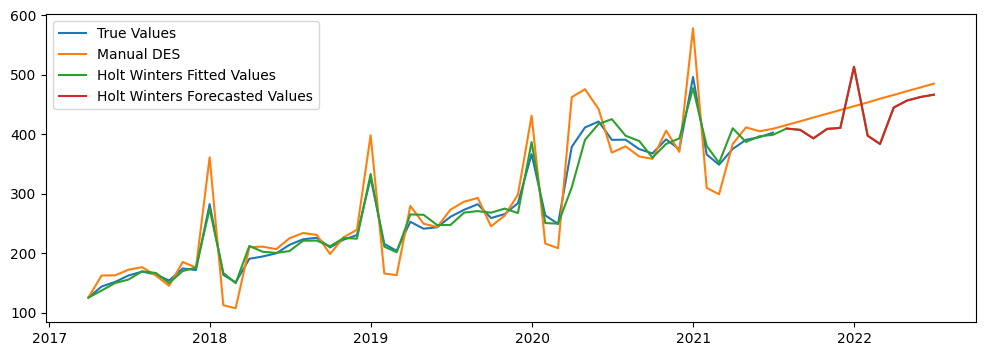

In [ ]:
fig = plt.figure(figsize = (12, 4))
ax = fig.add_subplot()

ax.plot(ts_sector_1["y"], label = "True Values")
ax.plot(manual_des_series, label = "Manual DES")
ax.plot(ts_sector_1_fitted_forecasted, label = "Holt Winters Fitted Values")
ax.plot(hw_model_forecast12, label = "Holt Winters Forecasted Values")

plt.legend()

<a id='conclusion'></a>
### Conclusión
[Volver al índice](#index)<br>

En este notebook hemos visto la teoría básica de las Series Temporales Univariante.

Se han tocado los modelos clásicos como ARIMA o Holt Winters y los más novedosos como Prophet.

A partir de ahora nos debemos sentir cómodos con los conceptos de medias móviles, modelos auto regresivos, series temporales estacionarias y los gráficos de ACF y PACF.

Hemos visto las técnicas básicas para convertir una Serie Temporal No Estacionaria en Estacionaria y también como podemos descomponer una Serie Temporal en Trend, Seasonal y Residual.

**Ante todo nos debemos quedar con que cada Serie Temporal es un mundo y hay que evaluarla y analizarla por separado.**

Por este motivo, hay que buscar el modelo que mejor se va a ajustar a cada problema.

En la siguiente sesión, veremos como podemos trabajar con Series Temporales Multivariante y usar el algoritmo de XGBoost.

### Referencias y lecturas recomendables
<a id='referencias'></a>
[Volver al índice](#index)<br>

A continuación dejamos algunos links útiles para profundizar en algunos de los conceptos que hemos visto en el notebook:

[ARIMA y método de Box Jenkins](https://www.estadistica.net/ECONOMETRIA/SERIES-TEMPORALES/modelo-arima.pdf)

[Forecasting: Principles and Practice (la Biblia de las Series Temporales)](https://otexts.com/fpp3/)

[Implementación Manual de Holt Winters](http://ethen8181.github.io/machine-learning/time_series/1_exponential_smoothing.html#Triple-Exponential-Smoothing---Holt-Winters-Method)

[How not to use Time Series Analysis Part I (MUY RECOMENDABLE)](https://www.linkedin.com/pulse/how-use-machine-learning-time-series-forecasting-vegard-flovik-phd/)

[How not to use Time Series Analysis Part II (MUY RECOMENDABLE)](https://www.linkedin.com/pulse/how-use-machine-learning-time-series-forecasting-vegard-flovik-phd-1f/)